# **Stochastic Resonance in a LIF Neuron: Effects of Noise on Spike-Signal Synchronization**

Neural systems operate in intrinsically noisy environments, yet they are remarkably effective at detecting and transmitting weak temporal signals. Rather than being merely detrimental, noise can under specific conditions enhance signal processing, a phenomenon known as Stochastic Resonance (SR). In SR, an optimal level of noise enables a nonlinear system to convert a subthreshold periodic input into a detectable output, whereas both insufficient and excessive noise impair signal transmission.

In this project, we investigate Stochastic Resonance in the context of neural dynamics using the Leaky Integrate-and-Fire (LIF) neuron model. We focus on how noise interacts with threshold dynamics to enhance temporal coding of a weak sinusoidal input. The analysis is structured hierarchically: we first characterize SR at the single-neuron level using phase-locking measures, then extend the study to neuronal populations, where collective activity enables more robust signal readout.

Beyond spike-level synchronization, we introduce population-level readouts based on pooled spike statistics, Peri-Stimulus Time Histograms (PSTHs), and frequency-domain analysis. This multi-level approach allows us to examine how SR manifests across different coding regimes, and how population averaging transforms sparse, noisy spiking into stable temporal representations. By systematically varying noise intensity, signal amplitude, and bias current, we provide a comprehensive and mechanistic account of noise-assisted temporal coding in neural populations.

### **Hypotheses**


**H1: Existence of an optimal noise level.**

In the presence of a subthreshold sinusoidal input, spike–signal synchronization, quantified by the Vector Strength, is not maximal in the absence of noise. Instead, it reaches a maximum at an intermediate noise intensity. Therefore, coherence is expected to show an inverted U-shaped dependence on noise level $\sigma$, which is the hallmark of stochastic resonance.

**H2: Dependence of the optimal noise level on signal amplitude**

The optimal noise intensity $\sigma_{\mathrm{opt}}$ depends on the amplitude $A$ of the sinusoidal input. For weaker signals, higher noise levels are required to induce phase-locked threshold crossings, leading to larger $\sigma_{\mathrm{opt}}$. Conversely, stronger subthreshold signals require less noise, resulting in smaller $\sigma_{\mathrm{opt}}$. This can be tested by comparing stochastic resonance curves across different values of $A$.

**H3: Dependence of the optimal noise level on the distance from threshold (DC bias)**

Varying the DC bias current $I_{\mathrm{bias}}$ changes the operating point of the neuron relative to threshold. When the neuron operates further below threshold, larger noise levels are needed for effective signal detection, yielding higher $\sigma_{\mathrm{opt}}$. When the neuron is closer to threshold (while remaining subthreshold), smaller noise intensities are sufficient, resulting in lower $\sigma_{\mathrm{opt}}$.

**H4: Performance degradation at high noise levels**

At high noise intensities, spike timing becomes dominated by stochastic fluctuations rather than by the sinusoidal input. As a result, the Vector Strength decreases toward values consistent with random phase firing, and spike trains lose phase locking. Excessive noise therefore degrades temporal coherence, completing the inverted U-shaped dependence characteristic of stochastic resonance.

**H5: Population-level robustness through averaging**

Pooling the activity of multiple independent neurons stabilizes temporal signal representations by reducing stochastic variability. Even when individual neurons fire sparsely, population-level readouts are expected to reveal coherent temporal structure through averaging across independent noise realizations.

### **Setup and definition of the reference LIF neuron**

The first step of the project is to establish a stable and well-controlled simulation environment by defining the computational unit used throughout the analysis: a Leaky Integrate-and-Fire (LIF) neuron. This model provides a minimal yet standard description of spiking dynamics and is widely used as a reference framework in computational neuroscience.

The implementation adopted here is based on the LIF reference code provided in the course laboratory material. Starting from that baseline, we introduce a small number of targeted modifications to improve numerical clarity and to ensure a precise control of spike timing and refractoriness, which are critical for the subsequent Stochastic Resonance analysis.

This initial configuration serves as a control condition, allowing us to later introduce subthreshold sinusoidal inputs and stochastic noise while keeping the underlying neuronal dynamics fixed.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

We define a utility function that initializes a dictionary containing the physiological parameters of the neuron and the simulation settings.
This function specifies the electrical properties of the LIF neuron and constructs the temporal grid used for numerical integration.

Compared to the original laboratory implementation, the time vector is built after applying parameter overrides, ensuring full consistency when simulation length or time step are modified.

In [ ]:
def default_pars(**kwargs):
    pars = {}
    # typical neuron parameters
    pars['V_th'] = -55.     # spike threshold [mV]
    pars['V_reset'] = -75.  # reset potential [mV]
    pars['tau_m'] = 10.     # membrane time constant [ms]
    pars['g_L'] = 10.       # leak conductance [nS]
    pars['V_init'] = -75.   # initial potential [mV]
    pars['E_L'] = -75.      # leak reversal potential [mV]
    pars['tref'] = 2.       # refractory time [ms]

    # simulation parameters
    pars['sim_len'] = 1000.0  # [ms]
    pars['dt'] = 0.1          # [ms]

    for k, v in kwargs.items():
        pars[k] = v

    sim_len = float(pars['sim_len'])
    dt = float(pars['dt'])
    pars['t_steps'] = np.arange(0.0, sim_len, dt, dtype=float)

    return pars

To facilitate inspection of the membrane dynamics, we define a plotting function that visualizes the membrane potential over time and explicitly marks the firing threshold. In the context of Stochastic Resonance, this visualization is useful to verify that inputs are genuinely subthreshold and to observe how noise-driven fluctuations interact with the threshold mechanism.

Spike times, when present, are displayed as vertical markers aligned with the threshold level.

In [ ]:
def plot_volt_trace(pars, v, sp):
    t = pars['t_steps']
    V_th = pars['V_th']

    plt.figure(figsize=(8, 3.5))
    plt.plot(t, v, lw=1.2, label='Membrane potential')
    plt.axhline(V_th, color='gray', ls='--', lw=1.2,
                label=r'Threshold $V_{\mathrm{th}}$')

    sp = np.asarray(sp, dtype=float)
    if sp.size > 0:
        ymin = min(np.min(v), pars.get('V_reset', np.min(v)))
        plt.vlines(sp, ymin=ymin, ymax=V_th, color='black',
                   alpha=0.4, lw=1, label='Spikes')

    plt.xlabel('Time (ms)')
    plt.ylabel('V (mV)')
    plt.title(f"Membrane potential trace | spikes = {len(sp)}", fontweight='bold')

    plt.ylim([-80, -40])

    plt.legend(loc='upper right', fontsize='small')
    plt.tight_layout()
    plt.show()

The `run_LIF` function was adapted from the course reference implementation to improve numerical clarity while preserving the original LIF equations. In the revised version, the membrane potential is clamped to the reset value for the full refractory period, preventing integration during refractoriness. Spike times are detected using a threshold-crossing criterion (from below to above threshold), ensuring unambiguous spike detection and accurate timing.

These adjustments do not modify the model itself, but provide a more robust implementation for synchronization and phase-locking analyses.

In [ ]:
def run_LIF(pars, I, stop=False):
    # Parameters
    V_th = float(pars["V_th"])
    V_reset = float(pars["V_reset"])
    tau_m = float(pars["tau_m"])
    g_L = float(pars["g_L"])
    V_init = float(pars["V_init"])
    E_L = float(pars["E_L"])
    dt = float(pars["dt"])
    t_steps = pars["t_steps"]
    tref = float(pars["tref"])

    t = int(t_steps.size)

    # Input current vector (constant or time-varying)
    I = np.asarray(I, dtype=float)
    if I.size == 1:
        I = float(I) * np.ones(t, dtype=float)
    else:
        assert I.shape[0] == t, "Input current must have same length as t_steps"
        I = I.copy()

    # finite-duration current pulse
    if stop:
        mid = t // 2
        width_steps = int(round(100.0 / dt))  # 100 ms each side
        left = max(0, mid - width_steps)
        right = min(t, mid + width_steps)
        I[:left] = 0.0
        I[right:] = 0.0

    # State initialization
    v = np.empty(t, dtype=float)
    v[0] = V_init
    rec_spikes = []

    # Refractory handling in discrete steps
    refrac_steps = max(int(round(tref / dt)), 0)
    refrac_count = 0  # number of future steps to clamp V to V_reset

    for i in range(t - 1):
        # Absolute refractory period: clamp voltage and skip integration
        if refrac_count > 0:
            v[i + 1] = V_reset
            refrac_count -= 1
            continue

        # Euler update of subthreshold dynamics
        dv = (-(v[i] - E_L) + I[i] / g_L) * (dt / tau_m)
        v_next = v[i] + dv

        # Spike detection by threshold crossing
        if (v[i] < V_th) and (v_next >= V_th):
            rec_spikes.append(t_steps[i + 1])  # spike time in ms
            v[i + 1] = V_reset
            refrac_count = max(refrac_steps - 1, 0)  # exact refractory length in steps
        else:
            v[i + 1] = v_next

    return v, np.asarray(rec_spikes, dtype=float)

As an initial validation step, we test the reference LIF neuron under a simple finite-duration current pulse.

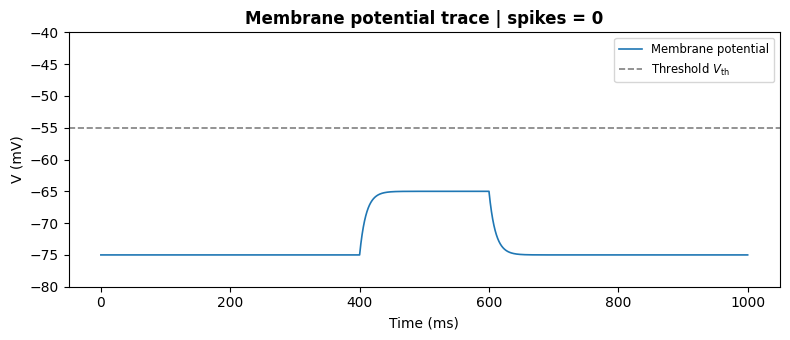

In [ ]:
pars = default_pars()
v, sp = run_LIF(pars, I=100, stop=True)
plot_volt_trace(pars, v, sp)

With the chosen parameters, the steady-state membrane potential under constant input is:

$$V_{\infty} = E_L + \frac{I}{g_L} = -75 \text{ mV} + \frac{100 \text{ pA}}{10 \text{ nS}} = -65 \text{ mV}$$

which remains below threshold ($V_{\text{th}} = -55 \text{ mV}$). Accordingly, the voltage trace shows a transient depolarization that stays subthreshold and no spikes are generated. This confirms that the neuron operates in the intended subthreshold regime, providing a reliable baseline for the next phase. In the stochastic resonance condition, the noise term will be implemented with Euler–Maruyama scaling ($\propto \sqrt{dt}$) to ensure noise statistics are independent of the chosen time step.

## **Stochastic Resonance experiment design and baseline definition**

In this phase, we move from the definition of a single neuron to the core of the computational experiment. The objective is to design a protocol that allows us to study how stochastic noise interacts with a subthreshold signal to modulate neural firing.

The experiment is organized into four sequential steps:


1.   **Baseline SR condition**: definition of a silent regime in which the signal is present but no spikes are generated.
2.   **Noise injection**: introduction of controlled Gaussian white noise as the key variable of the Stochastic Resonance mechanism.
3. **Core SR sweep**: systematic variation of the noise intensity to identify the optimal noise level that maximizes spike–signal synchronization (testing H1 and H4).
4. **Parametric exploration**: analysis of how the optimal noise level shifts with signal amplitude and distance from threshold (testing H2 and H3).



### **Baseline SR condition: subthreshold sinusoidal stimulation (σ = 0)**

We first define a deterministic baseline condition in which the neuron is driven by a sinusoidal input, but remains silent. This regime provides the reference state against which noise-induced effects will be quantified. The input current is constructed as

$$I(t) = I_{\text{bias}} + A \sin(2 \pi f t),$$

with parameters chosen so that membrane potential oscillations approach the firing threshold without crossing it in the absence of noise. To make this condition reproducible, we also report the safety margin

$$\Delta V = V_{\text{th}} - \max(V),$$

which should remain strictly positive at $\sigma = 0$.

In [ ]:
def build_subthreshold_sinusoid(pars, I_bias=178.0, A=20.0, f=10.0):
    # Time vector in seconds for sinusoidal modulation
    t_ms = pars['t_steps']
    t_s = t_ms * 1e-3
    # Deterministic subthreshold sinusoidal input current
    I_sin = I_bias + A * np.sin(2 * np.pi * f * t_s)
    return I_sin

To visualize and validate the baseline regime, we define a custom plotting function that displays the input current and the membrane potential in two vertically aligned panels.

In [ ]:
def plot_baseline_sr(pars, v, sp, I_sin, I_bias=None,
                     title="Baseline SR: Subthreshold sinusoid (σ = 0)"):

    t = pars['t_steps']
    V_th = pars['V_th']

    fig, (ax_in, ax_v) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    # Input current: deterministic signal only (no noise)
    ax_in.plot(t, I_sin, color='midnightblue', lw=1.2,
               alpha=0.9, label='Sinusoidal signal')

    if I_bias is not None:
        ax_in.axhline(I_bias, color='dimgray', ls='--',
                      lw=1.5, label=fr'Bias ($I_{{\mathrm{{bias}}}}$ = {I_bias} pA)')

    ax_in.set_ylabel('Input I(t) (pA)')
    ax_in.set_title(title, fontweight='bold', fontsize=12)
    ax_in.grid(True, alpha=0.3, linestyle=':')
    ax_in.legend(loc='upper right', fontsize='x-small', frameon=True)

    # Membrane potential and firing threshold
    ax_v.plot(t, v, color='crimson', lw=1.1, label=r'$V_m$')
    ax_v.axhline(V_th, color='black', ls='--', lw=1.2,
                 label=r'Threshold $V_{\mathrm{th}}$')

    # Spike markers (baseline condition should ideally show no spikes)
    if len(sp) > 0:
        ax_v.vlines(sp, ymin=-80, ymax=V_th, color='midnightblue',
                    alpha=0.35, lw=1, label='Spikes')

    ax_v.set_xlabel("Time (ms)")
    ax_v.set_ylabel("V (mV)")
    ax_v.set_ylim([-80, -40])
    ax_v.grid(True, alpha=0.3, linestyle=":")
    ax_v.legend(loc="upper right", fontsize="x-small", frameon=True)

    plt.tight_layout()
    plt.show()

We then run the simulation using a sinusoidal input with frequency $f = 10 \text{ Hz}$ and bias current $I_{\text{bias}} = 178 \text{ pA}$. This configuration places the membrane potential close to the firing threshold $V_{\text{th}} = -55 \text{ mV}$, while remaining strictly subthreshold.

[Baseline SR] max(V) = -55.50 mV, V_th = -55.0 mV, ΔV = 0.50 mV, spikes = 0


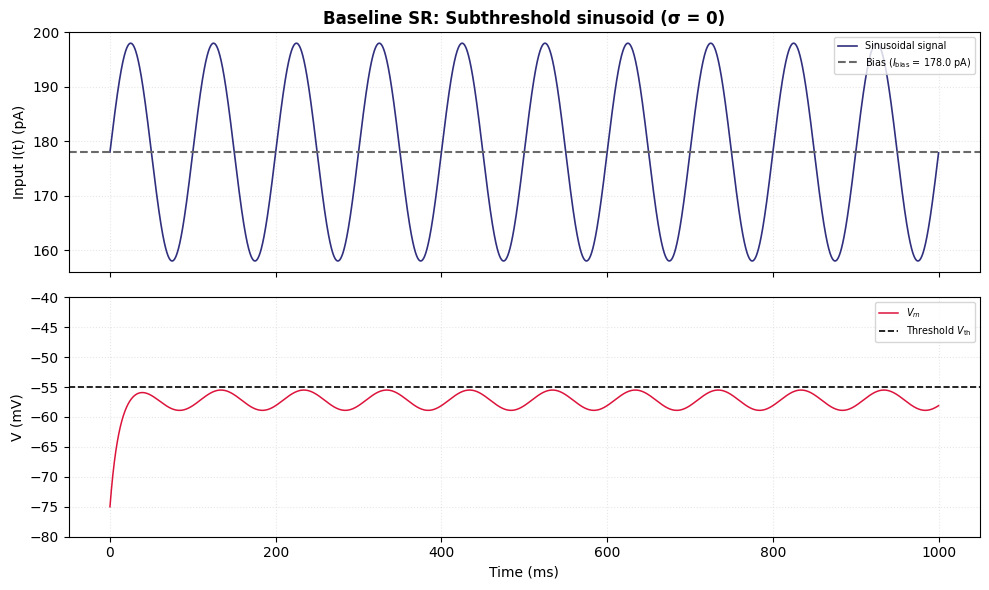

In [ ]:
pars = default_pars(sim_len=1000)

I_bias = 178.0  # pA (adds an explicit safety margin below threshold)
A = 20.0        # pA
f = 10.0        # Hz

I_sin = build_subthreshold_sinusoid(pars, I_bias=I_bias, A=A, f=f)

v, sp = run_LIF(pars, I=I_sin, stop=False)

V_max = np.max(v)
num_spikes = len(sp)
deltaV = pars['V_th'] - V_max
print(f"[Baseline SR] max(V) = {V_max:.2f} mV, V_th = {pars['V_th']} mV, "
      f"ΔV = {deltaV:.2f} mV, spikes = {num_spikes}")

plot_baseline_sr(pars, v, sp, I_sin, I_bias=I_bias)

The plot confirms that the sinusoidal input drives near-threshold oscillations of the membrane potential without eliciting spikes. We also report the safety margin $\Delta V $ to document that the baseline condition is strictly subthreshold ($\sigma = 0$).

This defines the baseline SR condition: the signal is present but not expressed in the output spike train. This silent regime provides the necessary reference state for the subsequent introduction of noise, where stochastic fluctuations will enable the recovery of temporal information through Stochastic Resonance.

### **Noise injection: Gaussian white noise with controlled intensity (σ)**

After defining the deterministic baseline, we introduce stochasticity by injecting Gaussian white noise into the input current. This step marks the transition from a purely deterministic regime to a stochastic one, while keeping the neuron close to threshold. Starting from the clean subthreshold sinusoid $I_{\text{sin}}(t)$, we construct a noisy input of the form:

$$I_{\text{tot}}(t) = I_{\text{sin}}(t) + I_{\text{noise}}(t)$$

Noise is generated as discretized Gaussian white noise and added at the current level. To ensure consistency with the Euler–Maruyama scheme, the noise parameter $\sigma$ is interpreted as a diffusion scale with units $\text{pA} \cdot \text{ms}^{1/2}$. When this option is enabled, noise samples are scaled as $\sigma / \sqrt{dt}$, so that the induced voltage fluctuations scale correctly as $\sqrt{dt}$ and remain independent of the chosen time step. A fixed random number generator (RNG) seed is used to ensure full reproducibility of the stochastic realization.

In [ ]:
def I_gaus(pars, mu=0.0, sigma=1.0, rng=None, scale_with_dt=False):
    t = int(np.asarray(pars["t_steps"]).size)

    if rng is None:
        z = np.random.standard_normal(t)
    else:
        z = rng.standard_normal(t)

    if scale_with_dt:
        dt_ms = float(pars["dt"])
        if dt_ms <= 0:
            raise ValueError(f"dt must be positive (ms). Got dt={dt_ms}.")
        z = z / np.sqrt(dt_ms)

    return float(mu) + float(sigma) * z

To visually assess the effect of noise, we update the plotting routine to display both the total noisy input and the underlying clean sinusoid, together with the resulting membrane potential and spike train.

In [ ]:
def build_noisy_input(pars, I_sin, sigma, mu_noise=0.0, rng=None, em_current_noise=True):
    t = int(np.asarray(pars["t_steps"]).size)

    I_sin = np.asarray(I_sin, dtype=float).reshape(-1)
    if I_sin.size != t:
        raise ValueError(
            f"I_sin must have length {t} (same as t_steps). Got shape {I_sin.shape}."
        )

    I_noise = I_gaus(pars, mu=mu_noise, sigma=sigma, rng=rng, scale_with_dt=em_current_noise)
    I_total = I_sin + I_noise
    return I_total, I_noise


def plot_sr_input_output(pars, v, sp, I_total, I_sin=None, I_bias=None,
                         title="SR Condition: Noise Injection"):
    t = pars['t_steps']
    V_th = pars['V_th']

    fig, (ax_in, ax_v) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    ax_in.plot(t, I_total, color='silver', lw=0.8, alpha=0.6,
               label='Total Input (Signal + Noise)')
    if I_sin is not None:
        ax_in.plot(t, I_sin, color='midnightblue', lw=1.5, alpha=0.8,
                   label='Clean Sinusoid')
    if I_bias is not None:
        ax_in.axhline(I_bias, color='dimgray', ls='--', lw=1.2,
                      label=fr'Bias ($I_{{\mathrm{{bias}}}}$ = {I_bias} pA)')

    ax_in.set_ylabel('Input I(t) (pA)')
    ax_in.set_title(title, fontweight='bold', fontsize=12)
    ax_in.grid(True, alpha=0.3, linestyle=':')
    ax_in.legend(loc='upper right', fontsize='x-small', frameon=True)

    ax_v.plot(t, v, color='crimson', lw=1.1, label=r'$V_m$')
    ax_v.axhline(V_th, color='black', ls='--', lw=1.2,
                 label=r'Threshold $V_{\mathrm{th}}$')
    sp = np.asarray(sp, dtype=float)
    if sp.size > 0:
        ax_v.vlines(sp, ymin=-80, ymax=V_th, color='midnightblue',
                    alpha=0.4, lw=1, label='Spikes')

    ax_v.set_xlabel('Time (ms)')
    ax_v.set_ylabel('V (mV)')
    ax_v.set_ylim([-80, -40])
    ax_v.grid(True, alpha=0.3, linestyle=':')
    ax_v.legend(loc='upper right', fontsize='x-small', frameon=True)

    plt.tight_layout()
    plt.show()

We then apply a moderate noise intensity ($\sigma = 2.0 \text{ pA} \cdot \text{ms}^{1/2}$) to the previously defined subthreshold input, keeping all other parameters unchanged.

[Noise injection] seed=42 | sigma=2.00 | spikes=0 | max(V)=-55.41 mV


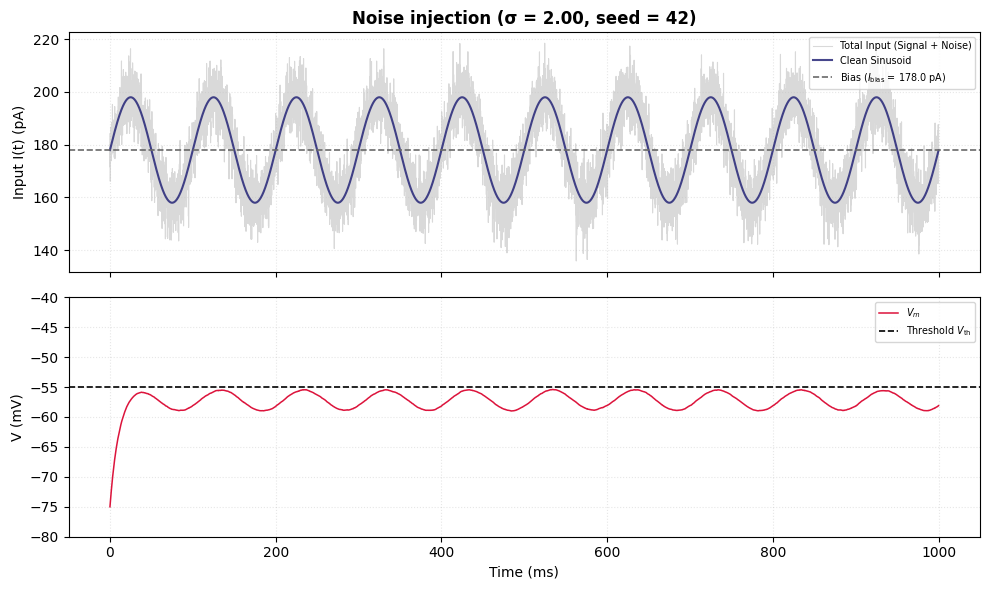

In [ ]:
rng = np.random.default_rng(42)

sigma = 2.0  # pA * sqrt(ms)  (diffusion scale for EM-consistent current noise)

I_total, I_noise = build_noisy_input(pars, I_sin, sigma=sigma, rng=rng, em_current_noise=True)

v, sp = run_LIF(pars, I=I_total, stop=False)

print(f"[Noise injection] seed=42 | sigma={sigma:.2f} | spikes={len(sp)} | max(V)={np.max(v):.2f} mV")

plot_sr_input_output(
    pars, v, sp,
    I_total=I_total,
    I_sin=I_sin,
    I_bias=I_bias,
    title=f"Noise injection (σ = {sigma:.2f}, seed = 42)"
)

The introduction of noise increases the variability of the input current and leads to larger membrane potential fluctuations compared to the deterministic baseline.

* Top panel. The total input current fluctuates around the hidden sinusoidal signal, while the underlying *10 Hz* structure remains clearly embedded in the noisy drive.

* Bottom panel. At this noise level, the membrane potential remains below threshold and no spikes are generated. This confirms that $\sigma = 2.0 \text{ pA} \cdot \text{ms}^{1/2}$ is still below the level required to induce noise-driven threshold crossings.

This step establishes a controlled stochastic regime without spiking activity. In the following section, the noise intensity $\sigma$ will be systematically increased
 to identify the range in which spikes emerge and stochastic resonance can be quantitatively characterized.


### **Core SR sweep: vary σ and quantify spike-signal synchronization**

To quantify stochastic resonance, we measure how well the output spike train is synchronized with the hidden sinusoidal input of frequency $f$. This is done by mapping each spike time to the phase of the sinusoid at the same instant and quantifying the concentration of these phases.

Spike times $t_k$ (in ms) are first converted to seconds and mapped to phases as:

$$\phi_k = (2 \pi f t_k) \pmod{2 \pi}$$

If spikes are unrelated to the input, phases are approximately uniform; if spikes are phase-locked, phases cluster around specific values.

Phase clustering is summarized by the Vector Strength:

$$R = \left| \frac{1}{N} \sum_{k=1}^{N} e^{i \phi_k} \right|$$

where $N$ is the number of spikes. Values $R \approx 0$ indicate no synchronization, while $R \approx 1$ indicates strong phase locking. If no spikes occur, $R$ is undefined and set to NaN.

Because Vector Strength estimates are unreliable for very small spike counts, each value is reported together with the number of spikes and flagged as unreliable if fewer than a minimum number of spikes are observed.

Before performing the full stochastic resonance sweep, we illustrate the phase-locking mechanism with a representative trial. Starting from the subthreshold input $I_{\text{sin}}(t)$, the noise intensity $\sigma$ is increased until a sufficient number of spikes is generated. For this selected $\sigma_{\text{demo}}$, spike phases and the corresponding Vector Strength are computed and visualized with a phase histogram.







In [ ]:
pars = default_pars(sim_len=10000)

I_sin = build_subthreshold_sinusoid(pars, I_bias=I_bias, A=A, f=f)

print(f"[SR sweep setup] sim_len={pars['sim_len']} ms | dt={pars['dt']} ms | cycles @ {f} Hz = {pars['sim_len']/1000*f:.0f}")

[SR sweep setup] sim_len=10000 ms | dt=0.1 ms | cycles @ 10.0 Hz = 100


In [ ]:
def spike_phases(spike_times_ms, f_hz):
    sp = np.asarray(spike_times_ms, dtype=float).reshape(-1)
    if sp.size == 0:
        return np.array([], dtype=float)
    t_s = sp / 1000.0
    return (2.0 * np.pi * float(f_hz) * t_s) % (2.0 * np.pi)


def vector_strength(spike_times_ms, f_hz):
    phases = spike_phases(spike_times_ms, f_hz)
    if phases.size == 0:
        return np.nan  # no spikes -> undefined
    return float(np.abs(np.mean(np.exp(1j * phases))))


def vector_strength_checked(spike_times_ms, f_hz, min_spikes=10):
    sp = np.asarray(spike_times_ms, dtype=float).reshape(-1)
    n = int(sp.size)
    reliable = (n >= int(min_spikes))
    R = vector_strength(sp, f_hz) if reliable else np.nan
    return R, n, reliable

def pick_sigma_for_demo(pars, I_sin, f_hz, seed, sigma_grid, min_spikes=10):
    v_last, sp_last = None, None

    for sigma in sigma_grid:
        rng = np.random.default_rng(int(seed))  # reset per sigma

        I_total, _ = build_noisy_input(
            pars, I_sin, sigma=float(sigma),
            rng=rng, em_current_noise=True
        )

        v, sp = run_LIF(pars, I=I_total, stop=False)
        v_last, sp_last = v, sp

        if len(sp) >= int(min_spikes):
            return float(sigma), v, sp

    return None, v_last, sp_last

[Vector Strength demo] seed=42 | sigma=15.00 (pA*sqrt(ms)) | spikes=25 | R=0.967 | reliable=True


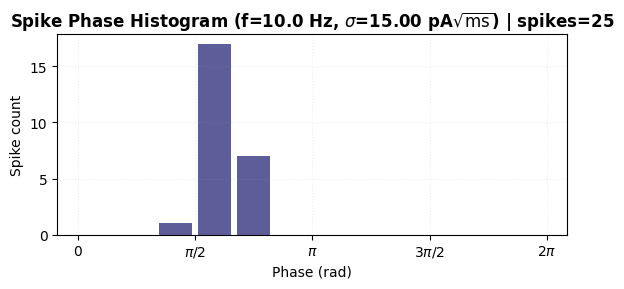

In [ ]:
rng = np.random.default_rng(42)

sigma_grid = [2, 4, 6, 8, 10, 15, 20, 30, 40]

# Candidate sigmas (pA*sqrt(ms)) for a visible example
sigma_demo, v, sp = pick_sigma_for_demo(
    pars, I_sin, f_hz=f, seed=42,
    sigma_grid=sigma_grid, min_spikes=10
)

if sigma_demo is None:
    print(f"[Vector Strength demo] No sigma in {sigma_grid} produced >=10 spikes (seed=42). "
          f"Try extending the grid or increasing sim_len.")
else:
    R, nsp, ok = vector_strength_checked(sp, f, min_spikes=10)
    print(f"[Vector Strength demo] seed=42 | sigma={sigma_demo:.2f} (pA*sqrt(ms)) | spikes={nsp} | R={R:.3f} | reliable={ok}")

    ph = spike_phases(sp, f)

    plt.figure(figsize=(6, 3))
    plt.hist(ph, bins=12, range=(0, 2*np.pi),
             color='midnightblue', alpha=0.7, rwidth=0.85)

    plt.xlabel("Phase (rad)")
    plt.ylabel("Spike count")
    plt.title(fr"Spike Phase Histogram (f={f:.1f} Hz, $\sigma$={sigma_demo:.2f} pA$\sqrt{{\mathrm{{ms}}}}$) | spikes={nsp}",
              fontweight='bold')
    plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi],
               ["0", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"])
    plt.grid(True, alpha=0.2, linestyle=':')
    plt.tight_layout()
    plt.show()

The phase histogram shows the distribution of spike times relative to the phase of the sinusoidal input.
A uniform distribution corresponds to the absence of phase locking ($R \approx 0$), whereas clustering around specific phases indicates synchronization between spikes and the signal ($R > 0$).
In this example, spike phases are clearly clustered within a restricted interval, resulting in a high Vector Strength ($R \approx 0.8$). This provides both qualitative and quantitative evidence that noise can reveal the temporal structure of a subthreshold signal.
This motivates the systematic analysis of spike–signal synchronization as a function of the noise intensity $\sigma$ in the following section.









**Core SR sweep: variation of σ and measurement of spike-signal synchronization**

In this step, we perform the core Stochastic Resonance (SR) sweep.The subthreshold sinusoidal input $I_{\sin}(t)$ (defined by $I_{\text{bias}}, A, f$) is kept fixed, while the noise intensity $\sigma$ is systematically varied.
For each value of $\sigma$:
* The total input current is constructed as: $I_{\text{tot}}(t) = I_{\sin}(t) + I_{\text{noise}}(t)$ where $I_{\text{noise}}$ is Gaussian white noise injected at the current level (Euler–Maruyama consistent, $\sigma$ in pA$\cdot\sqrt{\text{ms}}$).
* The LIF neuron is simulated and spike times are recorded.
* Spike–signal synchronization is quantified via the Vector Strength $R$, computed from spike phases relative to the sinusoidal input.

Because the system is stochastic, each condition is repeated over multiple independent trials ($n_{\text{trials}} = 20$, different random seeds). For each $\sigma$, we estimate:
* $R_{\text{mean}}$: mean Vector Strength over reliable trials.
* $R_{\text{std}}$: trial-to-trial variability.
* `spikes_mean`: mean number of spikes.
* `valid_trial_frac`: fraction of trials with at least `min_spike` spikes.

Only trials with a sufficient number of spikes are considered reliable to avoid spurious synchronization estimates.


In [ ]:
sigma_list = np.linspace(0.0, 60.0, 25).astype(float).tolist()  # pA*sqrt(ms)
n_trials = 20
min_spikes = 10
seed0 = 1000

R_mean_list = []
R_std_list = []
spike_mean_list = []
valid_frac_list = []

for s_idx, sigma in enumerate(sigma_list):
    R_trials = np.full(n_trials, np.nan, dtype=float)
    spk_trials = np.zeros(n_trials, dtype=float)
    reliable_trials = 0

    for trial in range(n_trials):
        # Independent seeds across both sigma and trial
        rng = np.random.default_rng(seed0 + 1000 * s_idx + trial)

        I_total, _ = build_noisy_input(
            pars, I_sin, sigma=float(sigma),
            rng=rng, em_current_noise=True
        )

        v, sp = run_LIF(pars, I=I_total, stop=False)

        R, nsp, ok = vector_strength_checked(sp, f, min_spikes=min_spikes)
        spk_trials[trial] = nsp

        if ok:
            R_trials[trial] = R
            reliable_trials += 1

    valid_frac = reliable_trials / n_trials

    R_mean = float(np.nanmean(R_trials)) if np.any(np.isfinite(R_trials)) else np.nan
    R_std  = float(np.nanstd(R_trials))  if np.any(np.isfinite(R_trials)) else np.nan

    R_mean_list.append(R_mean)
    R_std_list.append(R_std)
    spike_mean_list.append(float(np.mean(spk_trials)))
    valid_frac_list.append(float(valid_frac))

df_sr = pd.DataFrame({
    r"$\sigma$ (pA$\cdot\sqrt{\text{ms}}$)": np.array(sigma_list, dtype=float),
    r"$\text{R}_{\text{mean}}$ (reliable)": np.round(np.array(R_mean_list, dtype=float), 3),
    r"$\text{R}_{\text{std}}$ (reliable)":  np.round(np.array(R_std_list, dtype=float), 3),
    "spikes_mean": np.round(np.array(spike_mean_list, dtype=float), 1),
    "valid_trial_frac": np.round(np.array(valid_frac_list, dtype=float), 2),
})

display(df_sr)

,$\sigma$ (pA$\cdot\sqrt{\text{ms}}$),$\text{R}_{\text{mean}}$ (reliable),$\text{R}_{\text{std}}$ (reliable),spikes_mean,valid_trial_frac
0,0.0,NaN,NaN,0.0,0.00
1,2.5,NaN,NaN,0.0,0.00
2,5.0,NaN,NaN,0.0,0.00
3,7.5,NaN,NaN,0.8,0.00
4,10.0,0.991,0.002,6.2,0.15
5,12.5,0.967,0.008,14.4,0.90
6,15.0,0.961,0.010,27.4,1.00
7,17.5,0.947,0.013,38.4,1.00
8,20.0,0.935,0.012,46.2,1.00
9,22.5,0.921,0.016,54.4,1.00


The table reports, for each $\sigma$, the mean and standard deviation of the Vector Strength over reliable trials, together with the average spike count and the fraction of valid trials.

Interpretation of the sweep
* $\sigma \approx 0$: The signal is subthreshold, $R$ is undefined because no spikes are generated.
* Small $\sigma$: Noise occasionally induces threshold crossings near the signal peaks; $R$ increases, but variability can be high due to sparse spiking.
* Large $\sigma$: Spiking becomes dominated by noise; although spike count increases, phase locking degrades and $R$ decreases.

This behavior is characteristic of Stochastic Resonance.

After computing $R_{\text{mean}}$ for each $\sigma$, we define the optimal noise intensity $\sigma_{\text{opt}}$ as the value that maximizes $R_{\text{mean}}$, subject to a minimum fraction of reliable trials.



In [ ]:
MIN_VALID_FRAC = 0.5

R_mean_arr = np.asarray(R_mean_list, dtype=float)
valid_frac_arr = np.asarray(valid_frac_list, dtype=float)

eligible = np.isfinite(R_mean_arr) & (valid_frac_arr >= MIN_VALID_FRAC)

if np.any(eligible):
    best_idx = int(np.nanargmax(np.where(eligible, R_mean_arr, np.nan)))
    sigma_opt = float(sigma_list[best_idx])
    R_max = float(R_mean_arr[best_idx])
    print(f"[sigma_opt] Using valid_trial_frac >= {MIN_VALID_FRAC:.2f}")
    print(f"--> sigma_opt = {sigma_opt:.2f} pA*sqrt(ms) | R_mean = {R_max:.3f} | valid_frac = {valid_frac_arr[best_idx]:.2f}")
else:
    best_idx = int(np.nanargmax(R_mean_arr)) if np.any(np.isfinite(R_mean_arr)) else None
    if best_idx is None:
        sigma_opt = np.nan
        print("[sigma_opt] No finite R_mean values -> sigma_opt undefined.")
    else:
        sigma_opt = float(sigma_list[best_idx])
        R_max = float(R_mean_arr[best_idx])
        print(f"[sigma_opt] No sigma meets valid_trial_frac >= {MIN_VALID_FRAC:.2f}. Falling back to global max R_mean.")
        print(f"--> sigma_opt = {sigma_opt:.2f} pA*sqrt(ms) | R_mean = {R_max:.3f} | valid_frac = {valid_frac_arr[best_idx]:.2f}")

[sigma_opt] Using valid_trial_frac >= 0.50
--> sigma_opt = 12.50 pA*sqrt(ms) | R_mean = 0.967 | valid_frac = 0.90


For the chosen parameters ($I_{\text{bias}}$, $A$, $f$), a non-zero noise level maximizes spike–signal synchronization.


In [ ]:
df = pd.DataFrame({
    "sigma (pA)": np.array(sigma_list, dtype=float),
    "R_mean": np.array(R_mean_list, dtype=float),
    "R_std": np.array(R_std_list, dtype=float),
    "spikes_mean": np.array(spike_mean_list, dtype=float),
    "valid_trial_frac": np.array(valid_frac_list, dtype=float),
})

df["is_sigma_opt"] = False
if best_idx is not None:
    df.loc[best_idx, "is_sigma_opt"] = True

df_show = df.copy()
df_show["R_mean"] = df_show["R_mean"].round(3)
df_show["R_std"] = df_show["R_std"].round(3)
df_show["spikes_mean"] = df_show["spikes_mean"].round(1)
df_show["valid_trial_frac"] = df_show["valid_trial_frac"].round(2)

print("Summary Table:")
display(
    df_show.style.apply(
        lambda row: ["background-color: #f3f4f6"] * len(row) if row["is_sigma_opt"] else [""] * len(row),
        axis=1
    )
)

if best_idx is not None:
    print(f"\n--> sigma_opt = {sigma_opt:.2f} pA*sqrt(ms) | max R_mean = {df.loc[best_idx, 'R_mean']:.3f}")

Summary Table:


,sigma (pA),R_mean,R_std,spikes_mean,valid_trial_frac,is_sigma_opt
0,0.000000,nan,nan,0.000000,0.000000,False
1,2.500000,nan,nan,0.000000,0.000000,False
2,5.000000,nan,nan,0.000000,0.000000,False
3,7.500000,nan,nan,0.800000,0.000000,False
4,10.000000,0.991000,0.002000,6.200000,0.150000,False
5,12.500000,0.967000,0.008000,14.400000,0.900000,True
6,15.000000,0.961000,0.010000,27.400000,1.000000,False
7,17.500000,0.947000,0.013000,38.400000,1.000000,False
8,20.000000,0.935000,0.012000,46.200000,1.000000,False
9,22.500000,0.921000,0.016000,54.400000,1.000000,False



--> sigma_opt = 12.50 pA*sqrt(ms) | max R_mean = 0.967


The summary table shows that spike–signal synchronization, quantified by the mean Vector Strength, is maximized at an intermediate noise level. The optimal noise intensity $\sigma_{\text{opt}} \approx 12.5 \text{ pA} \cdot \sqrt{\text{ms}}$ is selected as the value that maximizes $R$ while satisfying a minimum reliability criterion on spike availability across trials. This non-monotonic dependence of synchronization on noise intensity provides a clear **validation of Hypothesis H1**.

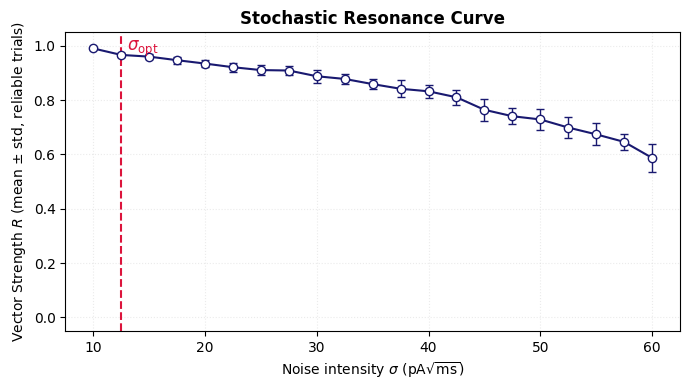

In [ ]:
sigma_arr = np.asarray(sigma_list, dtype=float)
R_mean_arr = np.asarray(R_mean_list, dtype=float)
R_std_arr  = np.asarray(R_std_list, dtype=float)

plt.figure(figsize=(7, 4))
plt.errorbar(
    sigma_arr, R_mean_arr, yerr=R_std_arr,
    fmt='o-', color='midnightblue',
    ecolor='midnightblue', elinewidth=1, capsize=3, mfc='white', ms=6
)

if best_idx is not None and np.isfinite(sigma_opt):
    plt.axvline(sigma_opt, color='crimson', linestyle='--', linewidth=1.5)
    plt.text(sigma_opt + 0.5, 0.98, r'$\sigma_{\mathrm{opt}}$',
             color='crimson', fontweight='bold', fontsize=12)

plt.xlabel(r'Noise intensity $\sigma$ (pA$\sqrt{\mathrm{ms}}$)')
plt.ylabel(r'Vector Strength $R$ (mean $\pm$ std, reliable trials)')
plt.title('Stochastic Resonance Curve', fontweight='bold')
plt.grid(True, alpha=0.25, linestyle=':')
plt.ylim(-0.05, 1.05)
plt.tight_layout()
plt.show()

The figure shows the Stochastic Resonance curve, reporting the mean Vector Strength $R$ ($\pm$ standard deviation across reliable trials) as a function of the noise intensity $\sigma$ (pA$\cdot\sqrt{\text{ms}}$).

For very low noise levels, the sinusoidal input remains subthreshold and no spikes are generated, so phase locking cannot be observed. As $\sigma$ increases, noise enables threshold crossings preferentially near the peaks of the sinusoidal signal, leading to a marked increase in spike–signal synchronization.

However, for larger noise intensities, spike timing becomes increasingly dominated by stochastic fluctuations. Despite a substantial increase in firing activity, the Vector Strength progressively decreases, indicating a loss of temporal alignment between spikes and the input signal. This degradation of phase locking at high noise levels provides a clear **validation of Hypothesis H4**, demonstrating that excessive noise impairs temporal synchronization even when spiking becomes abundant.



**Phase Collection at $\sigma_{\text{opt}}$**

After identifying the optimal noise level $\sigma_{\text{opt}}$ from the SR sweep (i.e., the value maximizing $R_{\text{mean}}$), we analyze where within the sinusoidal cycle spikes preferentially occur.

To obtain a robust estimate, the experiment is repeated over $n_{\text{trials}} = 50$ independent realizations (different random seeds), while keeping both the subthreshold sinusoidal input $I_{\text{sin}}(t)$ and the noise intensity fixed at $\sigma = \sigma_{\text{opt}}$.

For each trial:
* The total input current $I_{\text{tot}}(t) = I_{\text{sin}}(t) + I_{\text{noise}}(t)$ is generated.
* The LIF neuron is simulated and spike times are recorded.
* Each spike time is converted into the corresponding sinusoidal phase $\phi_k \in [0, 2\pi)$ using spike_phases.
* All spike phases are pooled across trials.

In this configuration, a total of 786 spikes are collected across 50 trials, corresponding to an average of 15.7 spikes per trial, providing a sufficient sample size.





In [ ]:
n_trials_phase = 50
seed0_phase = 2000

all_phases = []
R_trials = []
spikes_per_trial = []

for trial in range(n_trials_phase):
    rng = np.random.default_rng(seed0_phase + trial)

    I_total, _ = build_noisy_input(
        pars, I_sin,
        sigma=float(sigma_opt),
        rng=rng,
        em_current_noise=True
    )

    v, sp = run_LIF(pars, I=I_total, stop=False)

    ph = spike_phases(sp, f)
    if ph.size > 0:
        all_phases.append(ph)

    R_t, nsp, ok = vector_strength_checked(sp, f, min_spikes=10)
    R_trials.append(R_t)
    spikes_per_trial.append(nsp)

all_phases = np.concatenate(all_phases) if len(all_phases) > 0 else np.array([], dtype=float)
R_trials = np.asarray(R_trials, dtype=float)
spikes_per_trial = np.asarray(spikes_per_trial, dtype=float)

print(f"[Phase collection] sigma_opt = {sigma_opt:.2f} pA*sqrt(ms) | "
      f"trials={n_trials_phase} | total spikes pooled={all_phases.size} | "
      f"mean spikes/trial={spikes_per_trial.mean():.1f}")

[Phase collection] sigma_opt = 12.50 pA*sqrt(ms) | trials=50 | total spikes pooled=786 | mean spikes/trial=15.7


**Preferred phase estimation and phase histogram**

The pooled spike phases are visualized using a histogram over the interval $[0, 2\pi)$. If spikes were unrelated to the sinusoidal input, phases would be approximately uniform. In contrast, phase locking is revealed by a strong clustering around a specific phase.

The preferred phase is estimated using the circular mean:

$$\phi_{\text{pref}} = \text{arg} \left( \frac{1}{N} \sum_{k=1}^{N} e^{i \phi_k} \right)$$

which avoids artifacts due to phase wrap-around at $0 = 2\pi$.

[Phase collection] R_pooled=0.970 | R_mean_over_trials=0.972


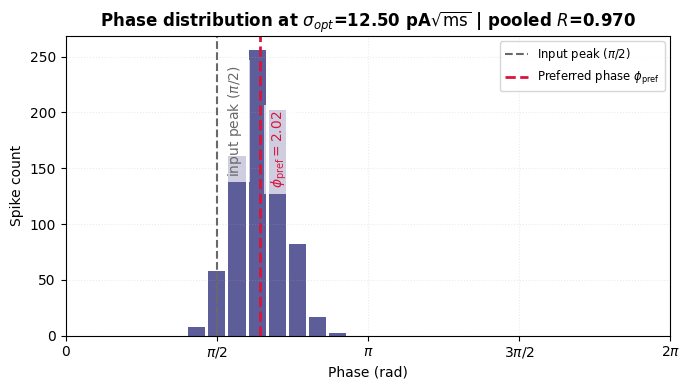

In [ ]:
if all_phases.size == 0:
    print("No spikes collected: phase histogram not defined.")
else:
    bins = 30

    z = np.mean(np.exp(1j * all_phases))
    R_pooled = float(np.abs(z))
    phi_pref = float(np.angle(z) % (2*np.pi))

    R_mean_over_trials = float(np.nanmean(R_trials)) if np.any(np.isfinite(R_trials)) else np.nan
    print(f"[Phase collection] R_pooled={R_pooled:.3f} | R_mean_over_trials={R_mean_over_trials:.3f}")

    plt.figure(figsize=(7, 4))
    plt.hist(all_phases, bins=bins, range=(0, 2*np.pi),
             color='midnightblue', alpha=0.7, rwidth=0.85)

    plt.axvline(np.pi/2, color='dimgray', linestyle="--", lw=1.5, label=r'Input peak ($\pi/2$)')
    plt.axvline(phi_pref, color='crimson', linestyle='--', lw=2, label=r'Preferred phase $\phi_{\mathrm{pref}}$')

    y_top = plt.ylim()[1]

    plt.text(np.pi/2 + 0.10, 0.90*y_top, r'input peak ($\pi/2$)', color='dimgray',
             rotation=90, va='top',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    plt.text(phi_pref + 0.10, 0.75*y_top, fr'$\phi_{{\mathrm{{pref}}}}={phi_pref:.2f}$', color='crimson',
             rotation=90, va='top', fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    plt.xlabel("Phase (rad)")
    plt.ylabel("Spike count")
    plt.title(fr"Phase distribution at $\sigma_{{opt}}$={sigma_opt:.2f} pA$\sqrt{{\mathrm{{ms}}}}$ | pooled $R$={R_pooled:.3f}",
              fontweight='bold')
    plt.xlim(0, 2*np.pi)
    plt.grid(True, alpha=0.25, linestyle=':')
    plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi],
               ["0", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"])
    plt.legend(loc="upper right", fontsize="small", frameon=True)
    plt.tight_layout()
    plt.show()

In the figure:
* The gray dashed line marks the input peak at $\pi/2$ (for a sine wave).
* The red dashed line indicates the estimated preferred spike phase $\phi_{\text{pref}}$.

At $\sigma_{\text{opt}} = 12.5 \text{ pA} \cdot \sqrt{\text{ms}}$, the phase histogram shows a pronounced and narrow concentration of spikes around the input peak.

The pooled Vector Strength is $R_{\text{pooled}} = 0.970$, fully consistent with the trial-averaged value $R_{\text{mean}} \approx 0.972$, confirming strong and stable phase locking.

The sharp clustering of spike phases demonstrates that, at the optimal noise level, spikes occur at predictable locations within the sinusoidal cycle rather than being randomly distributed.
This result provides a direct mechanistic explanation of the SR peak observed in the previous sweep: noise does not simply increase firing, but selectively enhances spike timing precision relative to the signal phase.

In [ ]:
def simulate_condition(pars, I_sin, sigma, f_hz, seed=1234, min_spikes=10):
    rng = np.random.default_rng(int(seed))
    I_total, _ = build_noisy_input(
        pars, I_sin,
        sigma=float(sigma),
        rng=rng,
        em_current_noise=True
    )
    v, sp = run_LIF(pars, I=I_total, stop=False)
    R, nsp, ok = vector_strength_checked(sp, f_hz, min_spikes=min_spikes)
    return I_total, v, sp, R, nsp, ok

We now define a comprehensive visualization tool to contrast the neuron's behavior across three critical states:
1. Low Noise (subthreshold)
2. Optimal Noise (Stochastic Resonance)
3. High Noise (saturation)

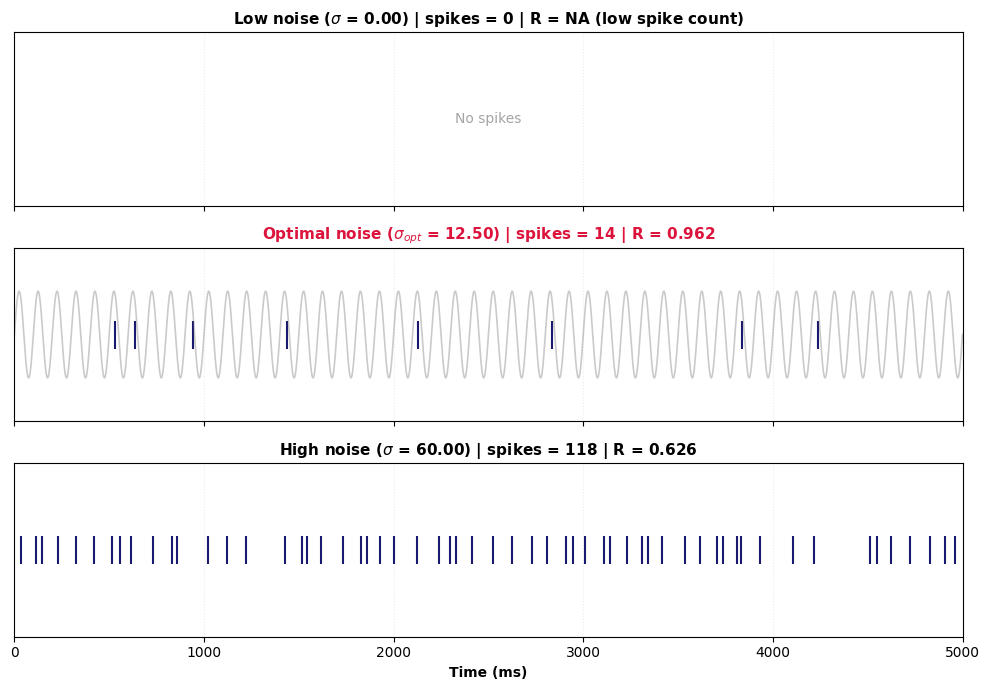

In [ ]:
def plot_raster_conditions(pars, I_sin, f_hz, sigma_opt,
                           sigma_low=0.0, sigma_high=60.0,
                           seed=2025, window_ms=(0, 5000),
                           overlay_signal=True, min_spikes=10):

    def _fmt_R(x):
        return "NA" if (x is None or (isinstance(x, float) and np.isnan(x))) else f"{x:.3f}"

    sigmas = [float(sigma_low), float(sigma_opt), float(sigma_high)]
    titles = [
        fr"Low noise ($\sigma$ = {sigma_low:.2f})",
        fr"Optimal noise ($\sigma_{{opt}}$ = {sigma_opt:.2f})",
        fr"High noise ($\sigma$ = {sigma_high:.2f})"
    ]

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)
    t = np.asarray(pars["t_steps"], dtype=float)
    t0, t1 = window_ms

    for j, (ax, sigma, title) in enumerate(zip(axes, sigmas, titles)):
        I_total, v, sp, R, nsp, ok = simulate_condition(
            pars, I_sin, sigma, f_hz,
            seed=seed + 1000*j,
            min_spikes=min_spikes
        )

        sp = np.asarray(sp, dtype=float)
        if sp.size > 0:
            ax.plot(sp, np.zeros_like(sp), marker='|', linestyle='None',
                    markersize=20, color='midnightblue', markeredgewidth=1.5)
        else:
            ax.text(0.5, 0.5, "No spikes", transform=ax.transAxes,
                    ha='center', va='center', fontsize=10, color='dimgray', alpha=0.6)

        extra = "" if ok else " (low spike count)"
        title_color = 'crimson' if np.isclose(sigma, sigma_opt) else 'black'
        ax.set_title(f"{title} | spikes = {nsp} | R = {_fmt_R(R)}{extra}",
                     fontweight="bold", fontsize=11, color=title_color)

        ax.grid(True, alpha=0.25, linestyle=':')
        ax.set_xlim(t0, t1)
        ax.set_yticks([])
        ax.set_ylim(-1, 1)

        if overlay_signal and np.isclose(sigma, sigma_opt):
            idx = (t >= t0) & (t <= t1)
            sin_seg = np.asarray(I_sin, dtype=float)[idx]
            if sin_seg.size > 1 and (sin_seg.max() - sin_seg.min() > 1e-12):
                sin_norm = (sin_seg - sin_seg.min()) / (sin_seg.max() - sin_seg.min())
                ax.plot(t[idx], sin_norm - 0.5, color="dimgray", alpha=0.35, lw=1.2)

    axes[-1].set_xlabel("Time (ms)", fontweight="bold")
    plt.tight_layout()
    plt.show()


sim_len = 10000
pars = default_pars(sim_len=sim_len)

I_bias = 178.0
A = 20.0
f = 10.0
I_sin = build_subthreshold_sinusoid(pars, I_bias=I_bias, A=A, f=f)

plot_raster_conditions(
    pars=pars,
    I_sin=I_sin,
    f_hz=f,
    sigma_opt=sigma_opt,
    sigma_low=0.0,
    sigma_high=60.0,
    seed=2025,
    window_ms=(0, 5000),
    overlay_signal=True,
    min_spikes=10
)

To complement the phase-based analysis, raster plots are used to compare spike timing across three representative noise regimes:
* **Low noise ($\sigma = 0.00$)**: The neuron remains silent, as the sinusoidal input is strictly subthreshold. No information is transmitted.
* **Optimal noise ($\sigma_{\text{opt}} = 12.50$)**: Spikes occur preferentially near the peaks of the sinusoidal input, resulting in strong phase locking ($R \approx 0.97$). Noise enables reliable, temporally precise threshold crossings.
* **High noise ($\sigma = 60.00$)**: Although the spike count increases substantially, spike timing becomes largely decorrelated from the signal phase, leading to reduced synchronization ($R \approx 0.58$).


These results confirm that Stochastic Resonance is not associated with maximal firing activity, but with an optimal trade-off between noise and temporal precision. At $\sigma_{\text{opt}}$, stochastic fluctuations reveal the hidden periodic structure of a subthreshold signal, transforming a silent neuron into a reliable encoder of temporal information.

### **Parametric exploration: shift **$\sigma_{\mathrm{opt}}$** with A and bias**

After establishing the existence of an optimal noise level $\sigma_{\mathrm{opt}}$, we move to a parametric analysis to test how robust this optimum is with respect to changes in the input configuration.
The optimal noise level is not an intrinsic property of the neuron, but emerges from the interaction between threshold dynamics and input parameters.

In this section we focus on:

* **Signal amplitude ($A$)**: how the strength of the sinusoidal input affects the amount of noise required to recover temporal information.

* **Operating point ($I_{\text{bias}}$)**: kept fixed to isolate amplitude effects.

This analysis tests Hypothesis H2, namely that $\sigma_{\mathrm{opt}}$ depends on the signal amplitude.







**Amplitude effect ($A$)**

To probe the effect of signal strength, we vary the sinusoidal amplitude $A$ while keeping frequency $f$ and bias current $I_{\text{bias}}=178$ pA constant.
Increasing $A$ reduces the distance between the membrane potential oscillations and the firing threshold, thus modifying the noise required to induce phase-locked spiking.

Two regimes are expected:

* **Large $A$**: the neuron operates close to threshold, so weak noise is sufficient and $\sigma_{\mathrm{opt}}$ is small.

* **Small $A$**: the neuron remains far from threshold, requiring stronger noise, shifting $\sigma_{\mathrm{opt}}$ to higher values.

In [ ]:
def get_sr_curve(
    pars, I_bias, A, f, sigma_list,
    n_trials=15, seed0=2000,
    min_spikes=10, max_spikes=400
):
    I_sin = build_subthreshold_sinusoid(pars, I_bias=I_bias, A=A, f=f)

    sigma_list = np.asarray(sigma_list, dtype=float).reshape(-1)

    R_means, R_stds = [], []
    spikes_means, valid_fracs = [], []

    for s_idx, sigma in enumerate(sigma_list):
        R_trials = np.full(int(n_trials), np.nan, dtype=float)
        spk_trials = np.zeros(int(n_trials), dtype=float)
        n_valid = 0

        for trial in range(int(n_trials)):
            rng = np.random.default_rng(int(seed0 + 1000 * s_idx + trial))

            I_tot, _ = build_noisy_input(
                pars, I_sin, sigma=float(sigma),
                rng=rng, em_current_noise=True
            )

            v, sp = run_LIF(pars, I=I_tot, stop=False)
            sp = np.asarray(sp, dtype=float).reshape(-1)
            nsp = int(sp.size)

            spk_trials[trial] = nsp

            if (nsp >= int(min_spikes)) and (nsp <= int(max_spikes)):
                R_trials[trial] = vector_strength(sp, f)
                n_valid += 1

        valid_frac = n_valid / float(n_trials)

        R_mean = float(np.nanmean(R_trials)) if np.any(np.isfinite(R_trials)) else np.nan
        R_std  = float(np.nanstd(R_trials))  if np.any(np.isfinite(R_trials)) else np.nan

        R_means.append(R_mean)
        R_stds.append(R_std)
        spikes_means.append(float(np.mean(spk_trials)))
        valid_fracs.append(float(valid_frac))

    return (
        np.asarray(R_means, dtype=float),
        np.asarray(R_stds, dtype=float),
        np.asarray(spikes_means, dtype=float),
        np.asarray(valid_fracs, dtype=float),
    )

For each amplitude $A \in \{5, 10, 15, 20\} \text{ pA}$, we compute a full SR curve by scanning $\sigma$ over a fixed range and repeating each condition over multiple independent trials. For each trial, spikes are mapped to sinusoidal phases and synchronization is quantified via the Vector Strength $R$.

Because Vector Strength estimates can be unstable when very few spikes are available, we compute $R$ only on valid trials, defined as trials with spike count within a conservative range:

$N_{\min} \leq N_{\text{spikes}} \leq N_{\max}$

In addition, $\sigma_{\text{opt}}$ is selected as the noise intensity maximizing the mean Vector Strength $R$ only among $\sigma$ (pA$\cdot\sqrt{\text{ms}}$) values where at least a minimum fraction of trials is valid (`valid_trial_frac ≥ 0.5`). This ensures that the optimum reflects reliable phase statistics rather than noise-driven sparse spiking.

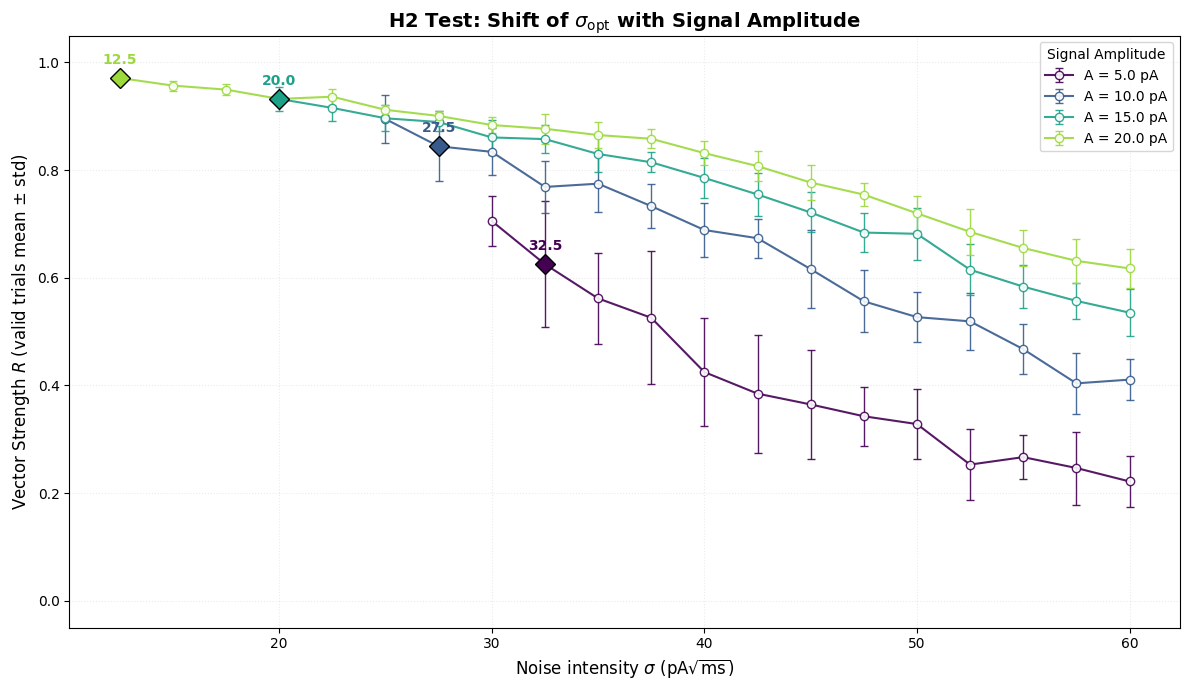

In [ ]:
pars = default_pars(sim_len=10000)

amplitudes = [5.0, 10.0, 15.0, 20.0]  # pA
f_hz = 10.0
I_bias_fixed = 178.0
n_trials_param = 15

sigma_sweep = np.linspace(0.0, 60.0, 25).astype(float)  # pA*sqrt(ms)

MIN_SPIKES = 10
MAX_SPIKES = 400  # ~40 Hz over 10 s
MIN_VALID_FRAC = 0.5

seed0_base = 2000

h2_results = {}

plt.figure(figsize=(12, 7))
colors = plt.cm.viridis(np.linspace(0, 0.85, len(amplitudes)))

for i, A in enumerate(amplitudes):

    seed0_A = int(seed0_base + 100000 * i)

    I_det = build_subthreshold_sinusoid(pars, I_bias=I_bias_fixed, A=A, f=f_hz)
    v0, sp0 = run_LIF(pars, I=I_det, stop=False)
    if len(sp0) > 0:
        print(
            f"[SKIP] I_bias={I_bias:.1f} pA produces spikes at σ=0 "
            "(not strictly subthreshold). Condition excluded."
        )
        continue


    r_mean, r_std, spk_mean, valid_frac = get_sr_curve(
        pars,
        I_bias=I_bias_fixed,
        A=A,
        f=f_hz,
        sigma_list=sigma_sweep,
        n_trials=n_trials_param,
        seed0=seed0_A,
        min_spikes=MIN_SPIKES,
        max_spikes=MAX_SPIKES
    )

    h2_results[A] = {
        "R_mean": r_mean,
        "R_std": r_std,
        "spikes_mean": spk_mean,
        "valid_frac": valid_frac,
        "seed0": seed0_A
    }

    r_mean = np.asarray(r_mean, dtype=float)
    valid_frac = np.asarray(valid_frac, dtype=float)

    eligible = np.isfinite(r_mean) & (valid_frac >= MIN_VALID_FRAC)

    if not np.any(eligible):
        print(
            f"[WARNING] A={A:.1f} pA → no sigma meets valid_frac >= {MIN_VALID_FRAC:.2f}. "
            "Skipping sigma_opt for this amplitude."
        )
        continue

    idx_opt = int(np.nanargmax(np.where(eligible, r_mean, np.nan)))
    s_opt = float(sigma_sweep[idx_opt])
    r_max = float(r_mean[idx_opt])

    plt.errorbar(
        sigma_sweep, r_mean, yerr=r_std,
        fmt='o-', color=colors[i], ecolor=colors[i],
        elinewidth=1, capsize=3, mfc='white', ms=6,
        alpha=0.9, linewidth=1.5, label=f'A = {A:.1f} pA'
    )

    plt.plot(
        s_opt, r_max, marker='D', color=colors[i], markersize=10,
        markeredgecolor='black', zorder=10
    )

    plt.annotate(
        f'{s_opt:.1f}',
        xy=(s_opt, r_max),
        xytext=(0, 10),
        textcoords='offset points',
        ha='center',
        fontsize=10,
        fontweight='bold',
        color=colors[i]
    )

plt.title(r'H2 Test: Shift of $\sigma_{\mathrm{opt}}$ with Signal Amplitude', fontsize=14, fontweight='bold')
plt.xlabel(r'Noise intensity $\sigma$ (pA$\sqrt{\mathrm{ms}}$)', fontsize=12)
plt.ylabel(r'Vector Strength $R$ (valid trials mean $\pm$ std)', fontsize=12)
plt.grid(True, alpha=0.25, linestyle=':')
plt.legend(title="Signal Amplitude", frameon=True, loc='upper right')
plt.ylim(-0.05, 1.05)
plt.tight_layout()
plt.show()

The resulting SR curves show a clear inverted U-shape for all amplitudes. Two systematic effects emerge:

1. Shift of $\sigma_{\mathrm{opt}}$: as the signal amplitude increases, the optimal noise level shifts toward lower values.

2. Increase in $R_{\max}$: higher amplitudes yield stronger maximal synchronization, indicating more precise phase locking.

These trends are visible both in the SR curves and in the extracted peak values.


In [ ]:
summary_list = []

for i, A in enumerate(amplitudes):
    r_mean = np.asarray(h2_results[A]["R_mean"], dtype=float)
    r_std  = np.asarray(h2_results[A]["R_std"], dtype=float)
    spk_m  = np.asarray(h2_results[A]["spikes_mean"], dtype=float)
    vfrac  = np.asarray(h2_results[A]["valid_frac"], dtype=float)

    eligible = np.isfinite(r_mean) & (vfrac >= MIN_VALID_FRAC)

    if not np.any(eligible):
        summary_list.append({
            "A (pA)": float(A),
            r"σ_opt (pA*sqrt(ms))": np.nan,
            "R_max (valid)": np.nan,
            "Std at σ_opt": np.nan,
            "spikes_mean@σ_opt": np.nan,
            "valid_trial_frac@σ_opt": np.nan,
        })
        continue

    idx_opt = int(np.nanargmax(np.where(eligible, r_mean, np.nan)))

    summary_list.append({
        "A (pA)": float(A),
        r"σ_opt (pA*sqrt(ms))": round(float(sigma_sweep[idx_opt]), 2),
        "R_max (valid)": round(float(r_mean[idx_opt]), 3),
        "Std at σ_opt": round(float(r_std[idx_opt]), 3),
        "spikes_mean@σ_opt": round(float(spk_m[idx_opt]), 1),
        "valid_trial_frac@σ_opt": round(float(vfrac[idx_opt]), 2),
    })

df_h2 = (
    pd.DataFrame(summary_list)
    .sort_values("A (pA)")
    .reset_index(drop=True)
)

display(df_h2)

,A (pA),σ_opt (pA*sqrt(ms)),R_max (valid),Std at σ_opt,spikes_mean@σ_opt,valid_trial_frac@σ_opt
0,5.0,32.5,0.625,0.117,13.5,0.87
1,10.0,27.5,0.844,0.065,13.3,0.93
2,15.0,20.0,0.932,0.023,12.6,0.80
3,20.0,12.5,0.971,0.010,16.5,0.93


The table below reports $\sigma_{\mathrm{opt}}$ and the corresponding maximum Vector Strength for each amplitude.

* $\sigma_{\mathrm{opt}}$ decreases monotonically with $A$, confirming that stronger signals require less noise.

* $R_{\max}$ increases with $A$, indicating improved temporal coding as the deterministic drive grows.

Together, these results provide a quantitative confirmation of Hypothesis H2:
the optimal noise level for Stochastic Resonance adapts systematically to the amplitude of the input signal.

**The Bias effect ($I_{\text{bias}}$)**

To test how the SR optimum depends on the neuron’s operating point, we vary the DC bias current $I_{\text{bias}}$ while keeping amplitude $A$ and frequency $f$ fixed. Increasing $I_{\text{bias}}$ shifts the mean membrane potential closer to threshold, reducing the effective distance that noise must bridge to elicit spikes.

We therefore expect a systematic shift of the resonance peak: higher $I_{\text{bias}}$ should lead to an optimal noise level at lower $\sigma$, whereas lower $I_{\text{bias}}$ should require stronger noise, shifting $\sigma_{\text{opt}}$ to higher values.

Using the same pipeline as in the amplitude study, we compute SR curves by sweeping $\sigma$ and averaging Vector Strength across trials. To ensure that phase-locking estimates are statistically meaningful, $R$ is computed only on trials with a sufficient number of spikes (and below saturation), and $\sigma_{\text{opt}}$ is selected only among noise levels with a minimum fraction of valid trials.

Finally, we restrict the bias range to conditions that remain subthreshold at $\sigma = 0$, so that spiking reflects noise-assisted threshold crossings rather than deterministic firing.

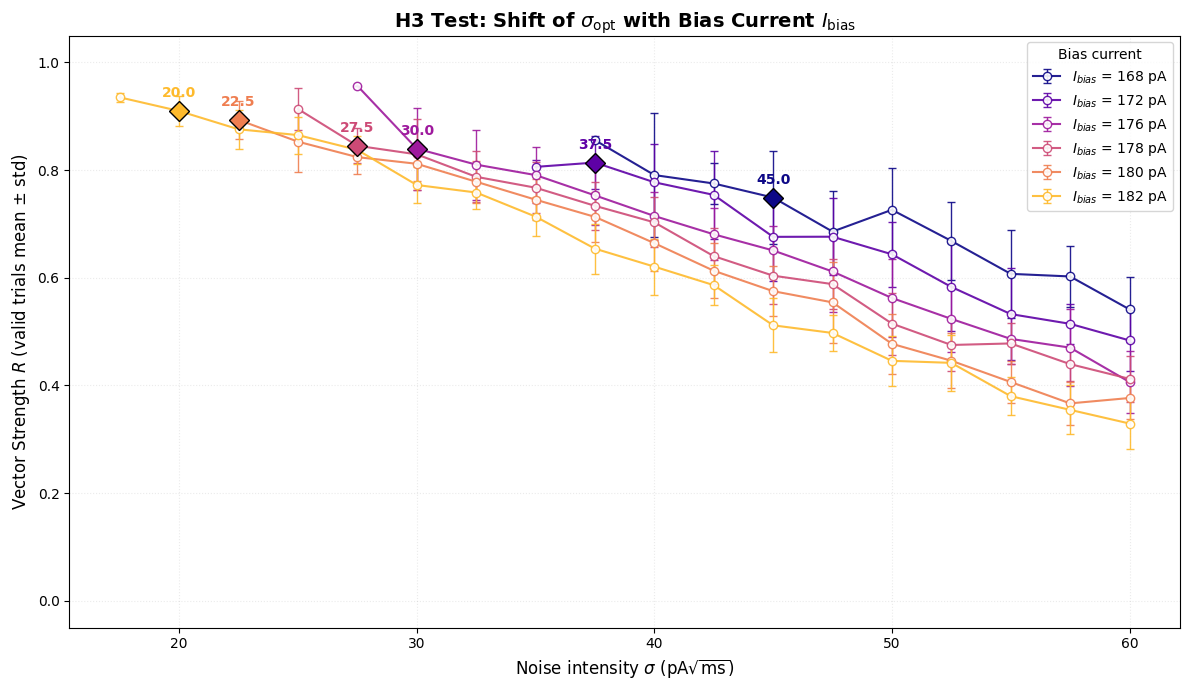

In [ ]:
A_fixed = 10.0

sigma_sweep = np.linspace(0.0, 60.0, 25).astype(float)

seed0_base = 3000

bias_values = [168, 172, 176, 178, 180, 182]

h3_bias_results = {}

plt.figure(figsize=(12, 7))
colors = plt.cm.plasma(np.linspace(0, 0.85, len(bias_values)))

for i, I_bias in enumerate(bias_values):

    seed0_I = int(seed0_base + 100000 * i)

    I_det = build_subthreshold_sinusoid(pars, I_bias=I_bias, A=A_fixed, f=f_hz)
    v0, sp0 = run_LIF(pars, I=I_det, stop=False)

    if len(sp0) > 0:
        print(
            f"[WARNING] I_bias={I_bias:.1f} pA produces spikes at sigma=0. "
            "Not subthreshold → consider lowering I_bias or A_fixed."
        )

    r_mean, r_std, spk_mean, valid_frac = get_sr_curve(
        pars,
        I_bias=I_bias,
        A=A_fixed,
        f=f_hz,
        sigma_list=sigma_sweep,
        n_trials=n_trials_param,
        seed0=seed0_I,
        min_spikes=MIN_SPIKES,
        max_spikes=MAX_SPIKES
    )

    h3_bias_results[I_bias] = {
        "R_mean": r_mean,
        "R_std": r_std,
        "spikes_mean": spk_mean,
        "valid_frac": valid_frac,
        "seed0": seed0_I
    }

    r_mean = np.asarray(r_mean, dtype=float)
    valid_frac = np.asarray(valid_frac, dtype=float)

    eligible = np.isfinite(r_mean) & (valid_frac >= MIN_VALID_FRAC)

    if not np.any(eligible):
        print(
            f"[WARNING] I_bias={I_bias:.1f} pA → no sigma meets valid_frac >= {MIN_VALID_FRAC:.2f}. "
            "Skipping sigma_opt for this bias."
        )
        continue

    idx_opt = int(np.nanargmax(np.where(eligible, r_mean, np.nan)))
    s_opt = float(sigma_sweep[idx_opt])
    r_max = float(r_mean[idx_opt])

    plt.errorbar(
        sigma_sweep, r_mean, yerr=r_std,
        fmt='o-', color=colors[i], ecolor=colors[i],
        elinewidth=1, capsize=3, mfc='white', ms=6,
        alpha=0.9, linewidth=1.5, label=fr'$I_{{bias}}$ = {I_bias:.0f} pA'
    )

    plt.plot(
        s_opt, r_max, marker='D', color=colors[i], markersize=10,
        markeredgecolor='black', zorder=10
    )

    plt.annotate(
        f'{s_opt:.1f}',
        xy=(s_opt, r_max),
        xytext=(0, 10),
        textcoords='offset points',
        ha='center',
        fontsize=10,
        fontweight='bold',
        color=colors[i]
    )

plt.title(r'H3 Test: Shift of $\sigma_{\mathrm{opt}}$ with Bias Current $I_{\mathrm{bias}}$', fontsize=14, fontweight='bold')
plt.xlabel(r'Noise intensity $\sigma$ (pA$\sqrt{\mathrm{ms}}$)', fontsize=12)
plt.ylabel(r'Vector Strength $R$ (valid trials mean $\pm$ std)', fontsize=12)
plt.grid(True, alpha=0.25, linestyle=':')
plt.legend(title="Bias current", frameon=True, loc='upper right')
plt.ylim(-0.05, 1.05)
plt.tight_layout()
plt.show()

The SR curves show that the resonance mechanism is preserved across bias conditions. Importantly, $\sigma_{opt}$ shifts systematically with $I_{bias}$: lower bias values require stronger noise to obtain phase-locked spikes, whereas higher bias values yield resonance at much lower noise. At high noise intensity, all curves decrease, confirming that excessive noise consistently disrupts phase locking.

To quantify the shift, we extract the peak coordinates for each bias condition. $\sigma_{\text{opt}}$ is defined as the maximizer of $R_{\text{mean}}$ among sigma values with valid_frac ≥ `MIN_VALID_FRAC`.

In [ ]:
summary_list = []

for I_bias in bias_values:
    r_mean = np.asarray(h3_bias_results[I_bias]["R_mean"], dtype=float)
    r_std  = np.asarray(h3_bias_results[I_bias]["R_std"], dtype=float)
    spk_m  = np.asarray(h3_bias_results[I_bias]["spikes_mean"], dtype=float)
    vfrac  = np.asarray(h3_bias_results[I_bias]["valid_frac"], dtype=float)

    eligible = np.isfinite(r_mean) & (vfrac >= MIN_VALID_FRAC)

    if not np.any(eligible):
        summary_list.append({
            "I_bias (pA)": float(I_bias),
            r"σ_opt (pA*sqrt(ms))": np.nan,
            "R_max (valid)": np.nan,
            "Std at σ_opt": np.nan,
            "spikes_mean@σ_opt": np.nan,
            "valid_trial_frac@σ_opt": np.nan,
        })
        continue

    idx_opt = int(np.nanargmax(np.where(eligible, r_mean, np.nan)))

    summary_list.append({
        "I_bias (pA)": float(I_bias),
        r"σ_opt (pA*sqrt(ms))": round(float(sigma_sweep[idx_opt]), 2),
        "R_max (valid)": round(float(r_mean[idx_opt]), 3),
        "Std at σ_opt": round(float(r_std[idx_opt]), 3),
        "spikes_mean@σ_opt": round(float(spk_m[idx_opt]), 1),
        "valid_trial_frac@σ_opt": round(float(vfrac[idx_opt]), 2),
    })

df_bias = (
    pd.DataFrame(summary_list)
    .sort_values("I_bias (pA)")
    .reset_index(drop=True)
)

display(df_bias)

,I_bias (pA),σ_opt (pA*sqrt(ms)),R_max (valid),Std at σ_opt,spikes_mean@σ_opt,valid_trial_frac@σ_opt
0,168.0,45.0,0.749,0.086,13.8,1.00
1,172.0,37.5,0.814,0.050,13.6,0.80
2,176.0,30.0,0.840,0.076,11.5,0.73
3,178.0,27.5,0.845,0.033,15.3,0.93
4,180.0,22.5,0.893,0.035,9.5,0.53
5,182.0,20.0,0.910,0.027,15.2,1.00


The table confirms the expected trend: $\sigma_{opt}$ decreases as $I_{bias}$ increases, meaning that bringing the neuron closer to threshold reduces the noise required to obtain resonance. The values of $R_{max}$ are generally higher at larger bias, indicating more reliable phase locking when the neuron operates nearer threshold.

Finally, we summarize the parametric sweeps by plotting $\sigma_{opt}$ as a function of signal amplitude $A$ (H2) and bias current $I_{bias}$ (H3).

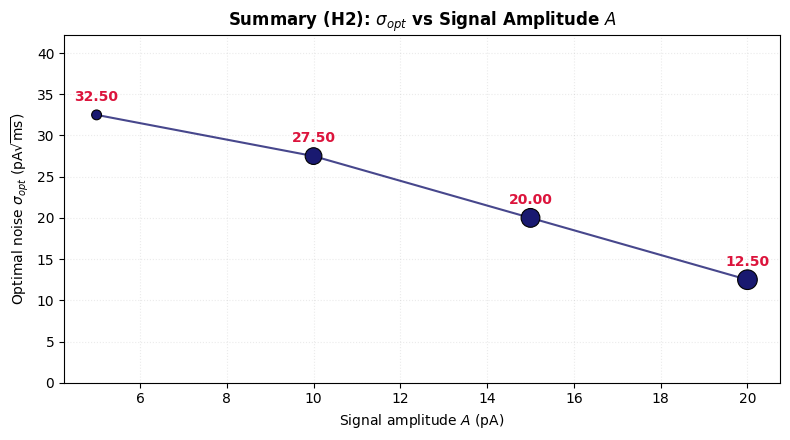

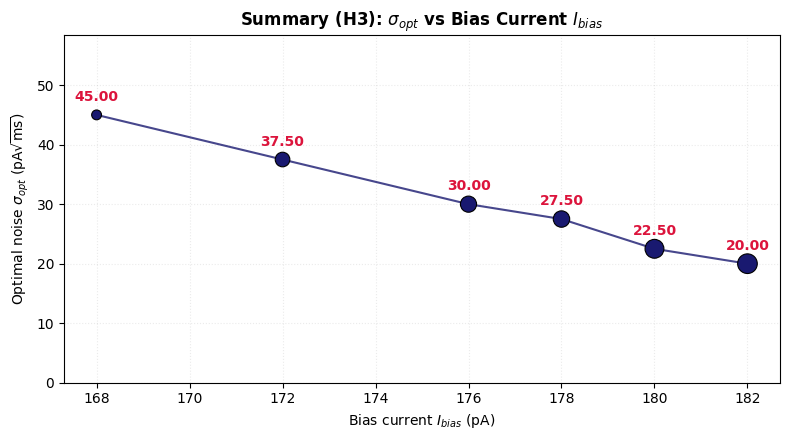

In [ ]:
def plot_sigma_opt_summary(df_h2, df_bias,
                           col_A="A (pA)", col_sigma_A="σ_opt (pA)", col_Rmax_A="R_max (valid)",
                           col_I="I_bias (pA)", col_sigma_I="σ_opt (pA)", col_Rmax_I="R_max (valid)"):

    plt.rcParams.update({
        "axes.grid": True,
        "grid.alpha": 0.25,
        "grid.linestyle": ":",
    })

    def marker_sizes_from_rmax(rmax_values, s_min=50, s_max=200):
        r = np.asarray(rmax_values, dtype=float)
        r = np.where(np.isfinite(r), r, np.nan)
        if np.any(np.isfinite(r)) and (np.nanmax(r) - np.nanmin(r) > 1e-12):
            r_norm = (r - np.nanmin(r)) / (np.nanmax(r) - np.nanmin(r))
            r_norm = np.where(np.isfinite(r_norm), r_norm, 0.0)
        else:
            r_norm = np.zeros_like(r, dtype=float)
        return s_min + r_norm * (s_max - s_min)

    # Plot 1: σ_opt vs A
    dfA = df_h2.copy().sort_values(col_A).reset_index(drop=True)
    A_vals = dfA[col_A].values
    sigA = dfA[col_sigma_A].values
    sizesA = marker_sizes_from_rmax(dfA[col_Rmax_A].values)

    sigA_finite = sigA[np.isfinite(sigA)]
    y_max_A = (np.max(sigA_finite) * 1.3) if sigA_finite.size > 0 else 1.0

    plt.figure(figsize=(8, 4.5))
    plt.plot(A_vals, sigA, color='midnightblue', linewidth=1.5, alpha=0.8)
    plt.scatter(A_vals, sigA, s=sizesA, color='midnightblue', edgecolors="black", linewidths=0.8, zorder=3)

    for x, y in zip(A_vals, sigA):
        if np.isfinite(y):
            plt.annotate(f"{y:.2f}", xy=(x, y), xytext=(0, 10), color='crimson',
                         textcoords="offset points", ha="center", fontweight='bold', fontsize=10)

    plt.title(r"Summary (H2): $\sigma_{opt}$ vs Signal Amplitude $A$", fontweight='bold')
    plt.xlabel(r"Signal amplitude $A$ (pA)")
    plt.ylabel(r"Optimal noise $\sigma_{opt}$ (pA$\sqrt{\mathrm{ms}}$)")
    plt.ylim(0, y_max_A)
    plt.tight_layout()
    plt.show()

    # Plot 2: σ_opt vs I_bias
    dfI = df_bias.copy().sort_values(col_I).reset_index(drop=True)
    I_vals = dfI[col_I].values
    sigI = dfI[col_sigma_I].values
    sizesI = marker_sizes_from_rmax(dfI[col_Rmax_I].values)

    sigI_finite = sigI[np.isfinite(sigI)]
    y_max_I = (np.max(sigI_finite) * 1.3) if sigI_finite.size > 0 else 1.0

    plt.figure(figsize=(8, 4.5))
    plt.plot(I_vals, sigI, color='midnightblue', linewidth=1.5, alpha=0.8)
    plt.scatter(I_vals, sigI, s=sizesI, color='midnightblue', edgecolors="black", linewidths=0.8, zorder=3)

    for x, y in zip(I_vals, sigI):
        if np.isfinite(y):
            plt.annotate(f"{y:.2f}", xy=(x, y), xytext=(0, 10), color='crimson',
                         textcoords="offset points", ha="center", fontweight='bold', fontsize=10)

    plt.title(r"Summary (H3): $\sigma_{opt}$ vs Bias Current $I_{bias}$", fontweight='bold')
    plt.xlabel(r"Bias current $I_{bias}$ (pA)")
    plt.ylabel(r"Optimal noise $\sigma_{opt}$ (pA$\sqrt{\mathrm{ms}}$)")
    plt.ylim(0, y_max_I)
    plt.tight_layout()
    plt.show()

plot_sigma_opt_summary(
    df_h2=df_h2,
    df_bias=df_bias,
    col_A="A (pA)",
    col_sigma_A="σ_opt (pA*sqrt(ms))",
    col_Rmax_A="R_max (valid)",
    col_I="I_bias (pA)",
    col_sigma_I="σ_opt (pA*sqrt(ms))",
    col_Rmax_I="R_max (valid)"
)

The summary plots reveal a clear and consistent inverse relationship between the optimal noise level and the neuron’s operating conditions:

* **Hypothesis 2 (Amplitude effect)**: $\sigma_{\text{opt}}$ systematically decreases as the signal amplitude $A$ increases. Stronger sinusoidal inputs bring the membrane potential closer to threshold during each cycle, reducing the amount of stochastic fluctuations required to elicit phase-locked spikes.

* **Hypothesis 3 (Bias effect)**: $\sigma_{\text{opt}}$ likewise decreases with increasing $I_{\text{bias}}$. Raising the bias shifts the mean membrane potential toward threshold, enhancing excitability and lowering the noise variance needed to achieve maximal synchronization.

Taken together, these results show that Stochastic Resonance is not a fixed property of the neuron, but an emergent phenomenon shaped by both input strength and intrinsic excitability. SR is most effective in near-threshold regimes, where moderate noise acts as a fine-tuning mechanism: it selectively reveals the temporal structure of weak signals without overwhelming them, enabling reliable phase-locked spiking while preserving temporal coherence.

## **Population-Level Stochastic Resonance**

The previous sections characterized Stochastic Resonance (SR) at the level of a single Leaky Integrate-and-Fire (LIF) neuron. While this analysis clarifies the noise-assisted detection mechanism, neural information in biological systems is typically encoded and read out at the population level, where variability of individual neurons is reduced through collective activity.

We therefore extend the model to a population of $N$ independent and identical LIF neurons. Each neuron $i$ obeys the same membrane dynamics:

$$\tau_m \frac{dV_i}{dt} = -(V_i - V_L) + R[I_{\text{sin}}(t) + \sigma \xi_i(t)]$$

where all neurons receive the same subthreshold sinusoidal input:

$$I_{\text{sin}}(t) = I_{\text{bias}} + A \sin(2 \pi f t)$$

and $\xi_i(t)$ denotes independent Gaussian noise for each neuron. No synaptic coupling or interactions are included, isolating the effect of population averaging.

Population activity is described by pooling spikes across neurons. The collective firing rate is estimated through the population Peri-Stimulus Time Histogram (PSTH):

$$r_{\text{pop}}(t) = \frac{1}{N} \sum_{i=1}^{N} \sum_{k} \delta(t - t_{k}^{(i)})$$

which provides a smooth population-level readout of the neural response.

Using this framework, we assess how Stochastic Resonance emerges in collective signals and how phase locking becomes more robust when information is pooled across neurons. Raster plots, pooled PSTHs, and aggregated phase-locking measures form a direct bridge between single-neuron dynamics and experimentally accessible population recordings.

We simulate a population of $N=50$ neurons over a fixed time window, using the same stimulus parameters as in the single-neuron analysis to ensure full consistency. The noise intensity $\sigma$ is varied to represent three representative regimes: no noise, optimal noise (as identified in the single-neuron SR analysis), and high noise. Independent noise realizations across neurons allow us to directly quantify how population averaging stabilizes phase locking and enhances the visibility of the underlying periodic signal.

In [ ]:
N_NEURONS = 50
SIM_LEN_MS = 10_000
DT_MS = 0.1

f_hz = 10.0
I_bias = 178.0
A = 20.0

BIN_MS = 10.0
WINDOW_MS = (0, 1000)

sigma_values = [0.0, 12.5, 60.0]  # example: low, sigma_opt, high

MIN_SPIKES = 10
MAX_SPIKES = 400         # 10 s -> 400 spikes corresponds to 40 Hz mean
MIN_VALID_FRAC = 0.5

seed_base = 2026

pars = default_pars(sim_len=SIM_LEN_MS, dt=DT_MS)
I_sin = build_subthreshold_sinusoid(pars, I_bias=I_bias, A=A, f=f_hz)

The following code implements the population simulation, computes pooled spike statistics and phase-locking measures, and prepares the data structures required for raster plots, PSTHs, and circular phase distributions.



In [ ]:
def simulate_population(
    pars, I_sin, sigma, f_hz,
    N_neurons=50,
    seed=1234,
    min_spikes=10,
    max_spikes=400,
    em_current_noise=True
):
    spikes_by_neuron = []
    pooled_spikes = []
    pooled_phases = []

    per_neuron_R = np.full(N_neurons, np.nan, dtype=float)
    valid_neurons = np.zeros(N_neurons, dtype=bool)

    for i in range(N_neurons):
        rng = np.random.default_rng(int(seed) + i)

        I_total, _ = build_noisy_input(
            pars, I_sin, sigma=sigma, rng=rng, em_current_noise=em_current_noise
        )
        _, sp = run_LIF(pars, I=I_total, stop=False)
        sp = np.asarray(sp, dtype=float)

        spikes_by_neuron.append(sp)

        nsp = sp.size
        if nsp > 0:
            pooled_spikes.append(sp)
            pooled_phases.append(spike_phases(sp, f_hz))

        if (nsp >= int(min_spikes)) and (nsp <= int(max_spikes)):
            per_neuron_R[i] = vector_strength(sp, f_hz)
            valid_neurons[i] = True

    all_spikes = np.concatenate(pooled_spikes) if pooled_spikes else np.array([], dtype=float)
    all_phases = np.concatenate(pooled_phases) if pooled_phases else np.array([], dtype=float)

    if np.any(valid_neurons):
        R_mean_neurons = float(np.nanmean(per_neuron_R))
        R_std_neurons = float(np.nanstd(per_neuron_R))
    else:
        R_mean_neurons = np.nan
        R_std_neurons = np.nan

    return {
        "spikes_by_neuron": spikes_by_neuron,
        "all_spikes": all_spikes,
        "all_phases": all_phases,
        "per_neuron_R": per_neuron_R,
        "valid_neuron_frac": float(valid_neurons.mean()),
        "R_mean_neurons": R_mean_neurons,
        "R_std_neurons": R_std_neurons,
    }


def pooled_vector_strength_from_phases(phases):
    phases = np.asarray(phases, dtype=float).reshape(-1)
    if phases.size == 0:
        return np.nan, np.nan
    z = np.mean(np.exp(1j * phases))
    R = float(np.abs(z))
    phi_pref = float(np.angle(z) % (2 * np.pi))
    return R, phi_pref


def compute_population_psth(all_spikes_ms, sim_len_ms, bin_ms, N_neurons):
    edges = np.arange(0.0, float(sim_len_ms) + float(bin_ms), float(bin_ms))
    counts, _ = np.histogram(all_spikes_ms, bins=edges)

    bin_s = float(bin_ms) / 1000.0
    rate_hz_per_neuron = counts / (float(N_neurons) * bin_s)

    centers_ms = edges[:-1] + float(bin_ms) / 2.0
    return centers_ms, rate_hz_per_neuron, counts


def summarize_population_condition(
    pars, I_sin, sigma, f_hz,
    N_neurons, seed, bin_ms,
    min_spikes=10,
    max_spikes=400,
    em_current_noise=True
):
    sim = simulate_population(
        pars, I_sin, sigma=sigma, f_hz=f_hz,
        N_neurons=N_neurons,
        seed=seed,
        min_spikes=min_spikes,
        max_spikes=max_spikes,
        em_current_noise=em_current_noise
    )

    R_pooled, phi_pref = pooled_vector_strength_from_phases(sim["all_phases"])

    sim_s = float(pars["sim_len"]) / 1000.0
    total_spikes = int(sim["all_spikes"].size)
    mean_rate = (total_spikes / sim_s) / float(N_neurons) if sim_s > 0 else np.nan

    centers_ms, rate_hz, _ = compute_population_psth(
        sim["all_spikes"], sim_len_ms=pars["sim_len"], bin_ms=bin_ms, N_neurons=N_neurons
    )

    return {
        "sigma": float(sigma),
        "total_spikes": total_spikes,
        "mean_rate_hz_per_neuron": float(mean_rate),
        "R_pooled": float(R_pooled) if np.isfinite(R_pooled) else np.nan,
        "phi_pref": float(phi_pref) if np.isfinite(phi_pref) else np.nan,
        **sim,
        "centers_ms": centers_ms,
        "rate_hz_per_neuron": rate_hz,
    }

To qualitatively assess Stochastic Resonance at the population level, we combine two complementary readouts:
* a population raster plot, showing spike timing across all neurons;
* a pooled Peri-Stimulus Time Histogram (PSTH), obtained by aggregating spikes across neurons and normalizing by population size.

For each noise condition, all neurons receive the same deterministic input $I_{\text{sin}}(t)$, while noise realizations are independent. This allows us to directly evaluate how population averaging enhances the temporal structure of the response.

The following function generates a master panel where each row corresponds to a different noise intensity $\sigma$. For each condition, the raster plot (left) is paired with the corresponding PSTH (right), using a consistent time window and shared scaling across conditions to enable direct visual comparison.

Phase-locking measures are computed only when a sufficient number of spikes is available, to ensure statistical reliability.

In [ ]:
def _fmt(x, nd=3):
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return "NA"
    return f"{x:.{nd}f}"

def plot_population_master_panel(results, pars, I_sin, f_hz, window_ms=(0, 1000), bin_ms=10.0):
    n_cases = len(results)
    t0, t1 = window_ms

    ymax = 0.0
    for res in results:
        centers = res["centers_ms"]
        rate = res["rate_hz_per_neuron"]
        mask = (centers >= t0) & (centers <= t1)
        if np.any(mask):
            ymax = max(ymax, float(np.max(rate[mask])))
    psth_ylim = (0, ymax * 1.10) if ymax > 0 else (0, 1)

    fig, axes = plt.subplots(
        n_cases, 2,
        figsize=(15, 3.6 * n_cases),
        sharex=True,
        constrained_layout=True,
        gridspec_kw={"width_ratios": [1.25, 1.0]}
    )
    if n_cases == 1:
        axes = np.array([axes])

    fig.set_constrained_layout_pads(w_pad=0.04, h_pad=0.08, hspace=0.02, wspace=0.06)

    N = len(results[0]["spikes_by_neuron"])

    t = np.asarray(pars["t_steps"], dtype=float)
    win_mask_t = (t >= float(t0)) & (t <= float(t1))

    I_sin = np.asarray(I_sin, dtype=float)
    denom = float(I_sin.max() - I_sin.min())
    sin_norm = (I_sin - I_sin.min()) / denom if denom > 1e-12 else np.zeros_like(I_sin)

    for i, res in enumerate(results):
        sigma = res["sigma"]

        # Raster
        ax_r = axes[i, 0]
        ax_r.eventplot(
            res["spikes_by_neuron"],
            colors="midnightblue",
            linewidths=0.45,
            lineoffsets=np.arange(N),
            linelengths=0.8
        )
        ax_r.set_xlim(t0, t1)
        ax_r.set_ylim(-1, N)
        ax_r.set_ylabel(fr"$\sigma={sigma:.2f}$" + "\nNeuron index", fontsize=10)

        if i == 0:
            ax_r.set_title("Population raster", fontweight="bold", pad=10)

        ax_r.grid(axis="x", alpha=0.25, linestyle=":")

        ax_r.text(
            0.985, 0.92,
            f"Mean rate: {res['mean_rate_hz_per_neuron']:.2f} Hz/neuron\n"
            f"Pooled R: {_fmt(res['R_pooled'])}\n"
            f"Valid neurons: {res['valid_neuron_frac']:.2f}\n"
            r"$\overline{R}$ neurons: " + f"{_fmt(res['R_mean_neurons'])}",
            transform=ax_r.transAxes,
            va="top", ha="right",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.9, edgecolor="silver"),
            fontsize=9
        )

        # PSTH
        ax_p = axes[i, 1]
        centers = res["centers_ms"]
        rate = res["rate_hz_per_neuron"]
        mask = (centers >= t0) & (centers <= t1)

        ax_p.plot(centers[mask], rate[mask], color="midnightblue", lw=1.8)
        ax_p.set_xlim(t0, t1)
        ax_p.set_ylim(psth_ylim)

        if i == 0:
            ax_p.set_title("Pooled PSTH", fontweight="bold", pad=10)

        ax_p.set_ylabel("Rate (Hz / neuron)")
        ax_p.grid(axis="x", alpha=0.25, linestyle=":")

        # Sinusoid guide
        if np.any(win_mask_t):
            sin_scaled = psth_ylim[0] + sin_norm * (psth_ylim[1] - psth_ylim[0])
            ax_p.plot(
                t[win_mask_t], sin_scaled[win_mask_t],
                color="silver", alpha=0.6, linestyle="--", lw=1.2
            )

        for ax in (ax_r, ax_p):
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)

    axes[-1, 0].set_xlabel("Time (ms)")
    axes[-1, 1].set_xlabel("Time (ms)")

    fig.suptitle(
        fr"Population SR readout (N={N}, bin={bin_ms:.0f} ms, f={f_hz:.1f} Hz)",
        fontsize=16, fontweight="bold"
    )

    plt.show()


We simulate the population response for three representative noise levels:
* $\sigma = 0$: absence of noise.
* $\sigma \approx \sigma_{\text{opt}}$: optimal Stochastic Resonance regime.
* High $\sigma$: noise-dominated regime.

To avoid artificial correlations across conditions, each noise level is assigned a distinct base seed. For each condition, we compute pooled spike statistics, population firing rates, and phase-locking measures using the same validity criteria adopted in the single-neuron analysis.

In [ ]:
results = []
for s_idx, s in enumerate(sigma_values):
    seed_sigma = int(seed_base + 100000 * s_idx)
    results.append(
        summarize_population_condition(
            pars, I_sin, sigma=float(s), f_hz=f_hz,
            N_neurons=N_NEURONS, seed=seed_sigma, bin_ms=BIN_MS,
            min_spikes=MIN_SPIKES, max_spikes=MAX_SPIKES
        )
    )

df = pd.DataFrame([{
    "sigma (pA*sqrt(ms))": r["sigma"],
    "total_spikes": r["total_spikes"],
    "mean_rate_hz_per_neuron": r["mean_rate_hz_per_neuron"],
    "R_pooled": r["R_pooled"],
    "valid_neuron_frac": r["valid_neuron_frac"],
    "R_mean_neurons": r["R_mean_neurons"],
    "R_std_neurons": r["R_std_neurons"],
} for r in results])

df_display = df.copy()
df_display["sigma (pA*sqrt(ms))"] = df_display["sigma (pA*sqrt(ms))"].map(lambda x: f"{x:.2f}")
df_display["mean_rate_hz_per_neuron"] = df_display["mean_rate_hz_per_neuron"].map(lambda x: f"{x:.3f}")
df_display["R_pooled"] = df_display["R_pooled"].map(lambda x: "NA" if np.isnan(x) else f"{x:.3f}")
df_display["valid_neuron_frac"] = df_display["valid_neuron_frac"].map(lambda x: "NA" if np.isnan(x) else f"{x:.2f}")
df_display["R_mean_neurons"] = df_display["R_mean_neurons"].map(lambda x: "NA" if np.isnan(x) else f"{x:.3f}")
df_display["R_std_neurons"] = df_display["R_std_neurons"].map(lambda x: "NA" if np.isnan(x) else f"{x:.3f}")

display(df_display)

,sigma (pA*sqrt(ms)),total_spikes,mean_rate_hz_per_neuron,R_pooled,valid_neuron_frac,R_mean_neurons,R_std_neurons
0,0.00,0,0.000,NA,0.00,NA,NA
1,12.50,801,1.602,0.968,0.98,0.971,0.011
2,60.00,6007,12.014,0.612,1.00,0.614,0.033


At **$\sigma = 0$**, the population is completely silent, confirming that the deterministic sinusoidal input is strictly subthreshold and unable to elicit spikes on its own.

At the **optimal noise level ($\sigma \approx 12.5$)**, sparse firing emerges across neurons, yet spikes are tightly phase-locked to the input. Despite the low firing rate, both pooled and single-neuron Vector Strengths are high, showing that population averaging stabilizes temporal coding even in a low-activity regime.

At **high noise ($\sigma = 60$)**, firing becomes dense but temporally disorganized. Although the total spike count increases, phase locking degrades, indicating that excessive noise disrupts temporal coherence.

Thus, population readouts amplify the hallmark of Stochastic Resonance: an optimal noise level converts sparse, phase-locked single-neuron activity into a clear and reliable population signal, while higher noise levels impair temporal precision despite increased firing.

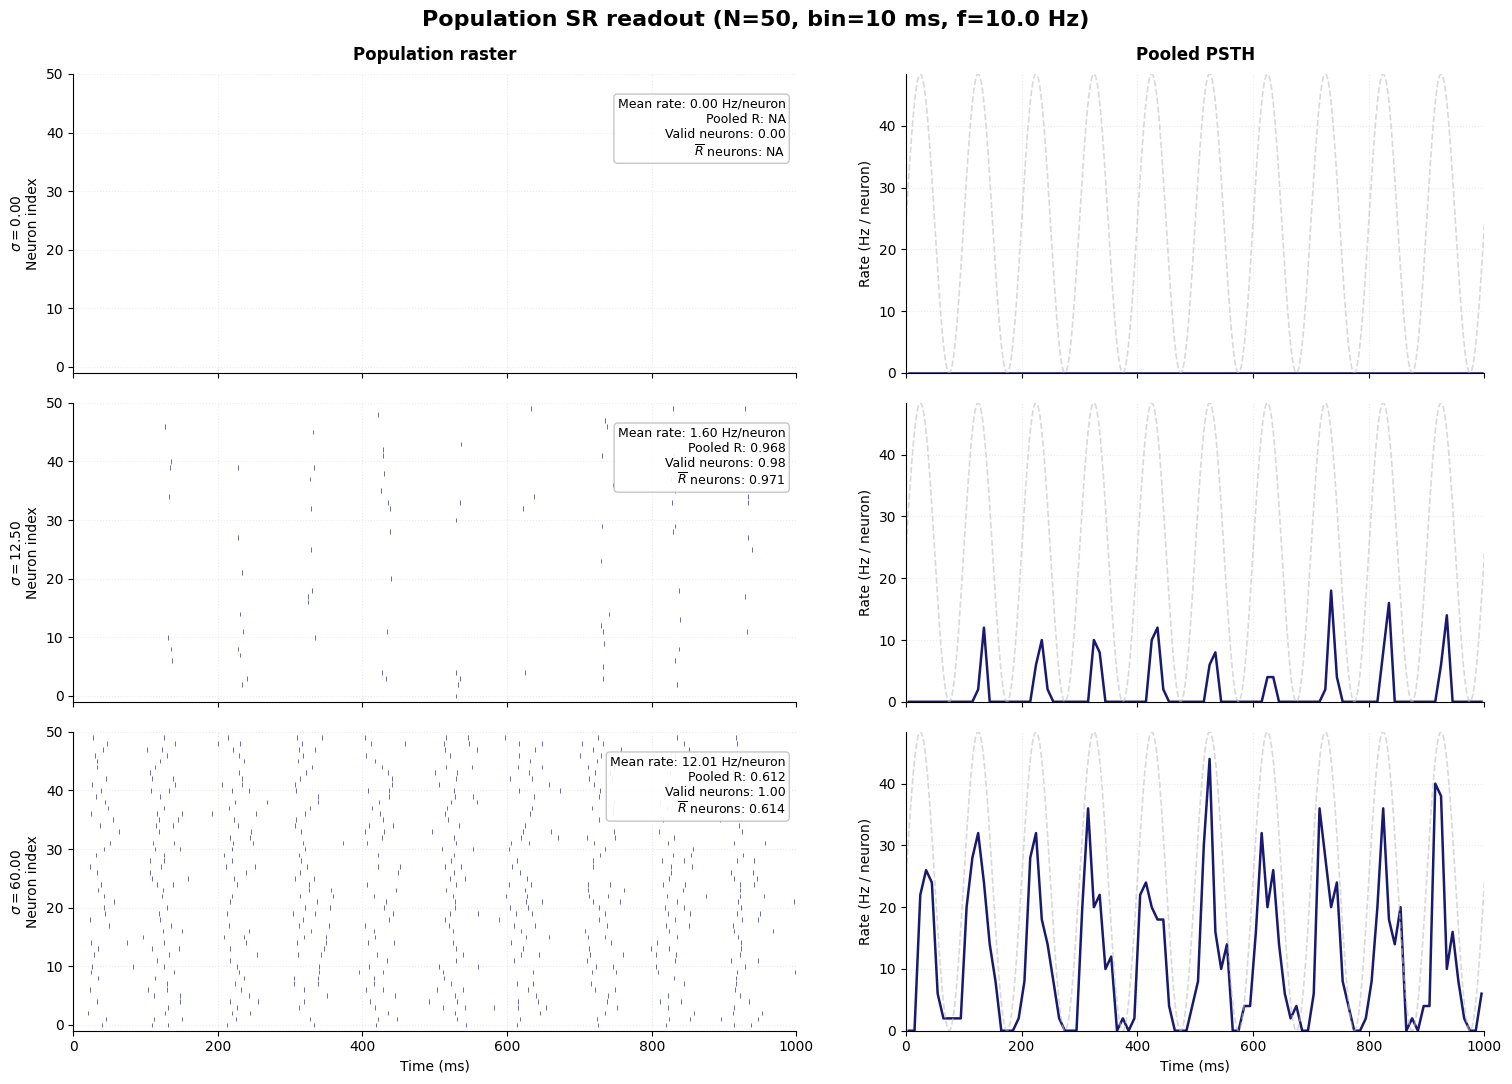

In [ ]:
plot_population_master_panel(results, pars, I_sin, f_hz=f_hz, window_ms=WINDOW_MS, bin_ms=BIN_MS)

At the population level, stochastic resonance appears as a trade-off between reliability and precision. When noise is absent, the signal is entirely lost; when noise is excessive, firing becomes abundant but poorly informative. Only at intermediate noise does the population collectively encode the stimulus phase in a stable way.

Crucially, strong phase locking emerges despite low firing rates per neuron. This shows that stochastic resonance in populations does not rely on high activity, but on the selective alignment of spikes across neurons. Independent noise realizations increase the number of stimulus-locked threshold crossings across the ensemble, so that pooling across neurons yields a smoother and more reliable estimate of the underlying periodic structure.

As noise increases further, the system shifts from a noise-assisted detection regime to a noise-dominated one: firing rate continues to grow, but temporal structure degrades. This dissociation highlights that rate and phase locking are governed by different mechanisms, and that stochastic resonance optimizes timing rather than excitability.

Importantly, **these results validate Hypothesis H5**: although single-neuron responses remain sparse and variable, pooling the activity of multiple independent neurons produces a stable and robust temporal representation of the input signal. Population averaging therefore acts as a noise-filtering mechanism that enhances temporal reliability beyond what is achievable at the single-neuron level.

To complement the raster/PSTH population readouts, we explicitly inspect where within the sinusoidal cycle population spikes occur. For each noise condition, we pool the spike phases from all neurons (same $I_{\text{sin}}(t)$, independent noise) and visualize their distribution on a circular histogram over $[0, 2\pi)$.

If spikes are not synchronized to the signal, phases should be close to uniform; conversely, phase locking produces a clear concentration around a preferred phase. In the same plot we report the pooled vector strength $R$ and indicate the preferred phase $\phi_{\text{pref}}$ with an arrow.

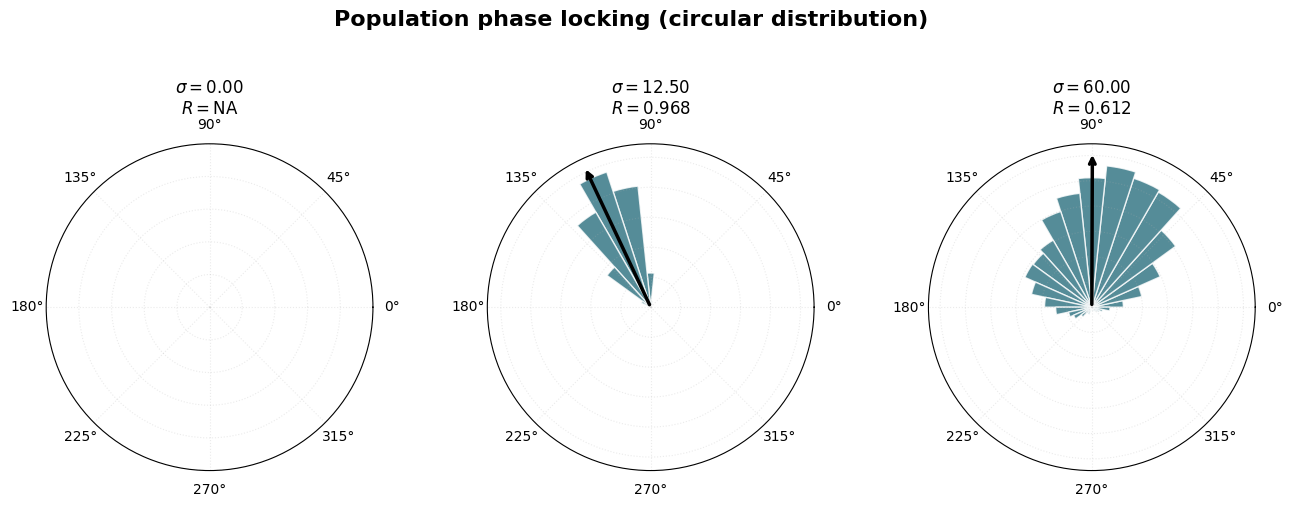

In [ ]:
def plot_population_phase_distribution(results, n_bins=30):
    n_cases = len(results)
    fig, axes = plt.subplots(
        1, n_cases,
        figsize=(5.2 * n_cases, 5.0),
        subplot_kw={'projection': 'polar'}
    )
    if n_cases == 1:
        axes = [axes]

    for i, res in enumerate(results):
        ax = axes[i]
        sigma = float(res["sigma"])
        phases = np.asarray(res.get("all_phases", np.array([], dtype=float)), dtype=float)

        ax.set_theta_zero_location("E")
        ax.set_theta_direction(1)
        ax.set_yticklabels([])
        ax.grid(alpha=0.25, linestyle=':')

        if phases.size == 0:
            ax.text(0.5, 1.08, rf"$\sigma = {sigma:.2f}$" + "\n" + r"$R=\mathrm{NA}$",
                    transform=ax.transAxes, ha='center', va='bottom', fontsize=12, fontweight='bold')
            continue

        counts, bins = np.histogram(phases, bins=n_bins, range=(0, 2*np.pi))
        centers = 0.5 * (bins[:-1] + bins[1:])
        width = bins[1] - bins[0]

        ax.bar(centers, counts, width=width, bottom=0.0, color="#2b6f7e", alpha=0.80, edgecolor="white", linewidth=1.0)

        R = res.get("R_pooled", np.nan)
        phi = res.get("phi_pref", np.nan)

        rmax = counts.max() * 1.15 if counts.max() > 0 else 1.0
        ax.set_rlim(0, rmax)

        if np.isfinite(R) and np.isfinite(phi):
            ax.annotate('', xy=(phi, 0.95 * rmax), xytext=(phi, 0.0),
                        arrowprops=dict(arrowstyle='->', lw=2.5, color='black'))

        ax.text(0.5, 1.08, rf"$\sigma = {sigma:.2f}$" + "\n" + rf"$R = {_fmt(R)}$",
                transform=ax.transAxes, ha='center', va='bottom', fontsize=12, fontweight='bold')

    fig.suptitle("Population phase locking (circular distribution)", fontsize=16, fontweight='bold', y=1.05)
    plt.subplots_adjust(top=0.80, wspace=0.35)
    plt.show()

plot_population_phase_distribution(results, n_bins=30)

Here:
* **$\sigma = 0$**: no spikes are produced (strictly subthreshold regime), therefore phase locking cannot be defined and $R$ is reported as NA. This is consistent with the SR framing: without noise, there is no threshold crossing and no temporal code to read out.
* **$\sigma = 12.5$**: phases cluster tightly in a narrow angular sector, and the arrow marks a stable $\phi_{\text{pref}}$. The very high $R \approx 0.97$ confirms strong population-level synchronization: noise is sufficient to trigger spikes, but crossings occur preferentially at a specific phase of the sinusoid (like the “signal structure” is preserved and amplified in the spike timing).
* **$\sigma = 60$**: the phase distribution becomes much broader. The preferred direction is still visible (arrow), but the spread increases and $R$ drops ($\sim 0.61$). This indicates that high noise maintains spiking but adds phase jitter, so timing becomes less informative even though activity is larger.

## **Frequency-Specific Population Readout**

To complement the time-domain analysis, we adopt a frequency-domain description of the population response. While the Vector Strength $R$ quantifies spike-level phase synchronization, a spectral analysis of the population activity provides a direct measure of how well the neuronal population reconstructs the periodic structure of the external input.

Population activity is described by the pooled firing rate $r_{\text{pop}}(t)$ which is estimated through a population Peri-Stimulus Time Histogram (PSTH). To isolate oscillatory components, the PSTH is first detrended:

$$\tilde{r}(t) = r_{\text{pop}}(t) - \langle r_{\text{pop}}(t) \rangle$$

and multiplied by a window function to reduce spectral leakage. We then compute the Fast Fourier Transform (FFT):

$$R(f) = \text{FFT}\{\tilde{r}(t)\}$$

and extract the amplitude of the spectral component at the stimulation frequency $f_0 = 10 \text{ Hz}$:

$$A_{10} = |R(f_0)|$$

which quantifies the strength of the population-level oscillatory readout. In addition, we define a local Signal-to-Noise Ratio (SNR) around $f_0$ by comparing the power at the target frequency to the average power of neighboring frequencies:

$$\text{SNR} = \frac{|R(f_0)|^2}{\text{mean}(|R(f)|^2)_{\text{noise}}}$$

$$\text{SNR}_{\text{dB}} = 10 \log_{10}(\text{SNR})$$

For each noise level $\sigma$, the spectral amplitude $A_{10}$ and the corresponding SNR are computed and stored together with the pooled Vector Strength. This allows a direct comparison between spike-level synchronization and population-level signal amplification, providing a frequency-specific characterization of Stochastic Resonance in neural populations.

In [ ]:
def psth_spectrum_target(centers_ms, rate_hz_per_neuron, target_hz, window="hann"):
    t_s = np.asarray(centers_ms, dtype=float) / 1000.0
    x = np.asarray(rate_hz_per_neuron, dtype=float)

    n = x.size
    if n < 8:
        return {"A_target": np.nan, "freqs": None, "amps": None, "fs_hz": np.nan, "df_hz": np.nan, "T_s": np.nan}

    dt = float(np.mean(np.diff(t_s)))
    if (not np.isfinite(dt)) or dt <= 0:
        return {"A_target": np.nan, "freqs": None, "amps": None, "fs_hz": np.nan, "df_hz": np.nan, "T_s": np.nan}

    fs_hz = 1.0 / dt
    nyq = fs_hz / 2.0
    T_s = n * dt
    df_hz = 1.0 / T_s if T_s > 0 else np.nan

    if target_hz > nyq:
        return {"A_target": np.nan, "freqs": None, "amps": None, "fs_hz": fs_hz, "df_hz": df_hz, "T_s": T_s}

    x = x - np.mean(x)

    w = np.ones(n, dtype=float)
    if window is not None:
        wname = str(window).lower()
        if wname == "hann":
            w = np.hanning(n)
        elif wname == "hamming":
            w = np.hamming(n)

    xw = x * w

    X = np.fft.rfft(xw)
    freqs = np.fft.rfftfreq(n, d=dt)

    scale = 2.0 / np.sum(w)
    amps = scale * np.abs(X)
    amps[0] *= 0.5
    if (n % 2 == 0) and (amps.size > 1):
        amps[-1] *= 0.5

    k = int(np.argmin(np.abs(freqs - target_hz)))
    A_target = float(amps[k])

    return {"A_target": A_target, "freqs": freqs, "amps": amps, "fs_hz": fs_hz, "df_hz": df_hz, "T_s": T_s}


def local_snr_around_target(freqs, amps, target_hz, band_hz=2.0, guard_hz=0.6, agg="median"):
    if freqs is None or amps is None:
        return np.nan, np.nan

    freqs = np.asarray(freqs, dtype=float)
    amps = np.asarray(amps, dtype=float)
    if freqs.size < 5:
        return np.nan, np.nan

    k0 = int(np.argmin(np.abs(freqs - target_hz)))
    A_sig = float(amps[k0])
    P_sig = A_sig**2

    band_mask  = (freqs >= (target_hz - band_hz)) & (freqs <= (target_hz + band_hz))
    guard_mask = (freqs >= (target_hz - guard_hz)) & (freqs <= (target_hz + guard_hz))
    noise_mask = band_mask & (~guard_mask)

    if np.sum(noise_mask) < 3:
        return np.nan, np.nan

    noise_vals = (amps[noise_mask]**2)
    P_noise = float(np.median(noise_vals)) if agg == "median" else float(np.mean(noise_vals))

    if (not np.isfinite(P_noise)) or P_noise <= 0:
        return np.nan, np.nan

    snr_lin = P_sig / P_noise
    snr_db = 10.0 * np.log10(snr_lin)
    return float(snr_lin), float(snr_db)

The spectral readout is applied to each previously simulated noise condition. For every value of the noise standard deviation $\sigma$, the $10 \text{ Hz}$ amplitude and local SNR are computed and stored together with the pooled Vector Strength.

In [ ]:
for r in results:
    spec = psth_spectrum_target(
        r["centers_ms"],
        r["rate_hz_per_neuron"],
        target_hz=f_hz,
        window="hann"
    )

    r["A_10Hz"] = spec["A_target"]

    snr_lin, snr_db = local_snr_around_target(
        spec["freqs"], spec["amps"],
        target_hz=f_hz,
        band_hz=2.0,
        guard_hz=0.6,
        agg="median"
    )
    r["SNR10_dB"] = snr_db

In [ ]:
df = pd.DataFrame([{
    r"sigma (pA*sqrt(ms))": r["sigma"],
    "mean_rate_hz_per_neuron": r["mean_rate_hz_per_neuron"],
    "R_pooled": r["R_pooled"],
    "A_10Hz (PSTH)": r["A_10Hz"],
    "SNR10_dB": r["SNR10_dB"],
} for r in results])

df_display = df.copy()
df_display[r"sigma (pA*sqrt(ms))"] = df_display[r"sigma (pA*sqrt(ms))"].map(lambda x: f"{x:.2f}")
df_display["mean_rate_hz_per_neuron"] = df_display["mean_rate_hz_per_neuron"].map(lambda x: f"{x:.3f}")
df_display["R_pooled"] = df_display["R_pooled"].map(lambda x: "NA" if np.isnan(x) else f"{x:.3f}")
df_display["A_10Hz (PSTH)"] = df_display["A_10Hz (PSTH)"].map(lambda x: "NA" if np.isnan(x) else f"{x:.3f}")
df_display["SNR10_dB"] = df_display["SNR10_dB"].map(lambda x: "NA" if np.isnan(x) else f"{x:.2f}")

display(df_display)

,sigma (pA*sqrt(ms)),mean_rate_hz_per_neuron,R_pooled,A_10Hz (PSTH),SNR10_dB
0,0.00,0.000,NA,0.000,NA
1,12.50,1.602,0.968,3.012,30.13
2,60.00,12.014,0.612,14.525,38.55


The table summarizes the frequency-domain readout for the different noise conditions, together with the pooled phase-locking measure. At $\sigma = 0$, the PSTH is identically zero (no spikes), hence both the 10 Hz amplitude and SNR are not meaningful / collapse to baseline. At higher noise, the firing rate increases and the 10 Hz component may remain visible (or even increase in absolute amplitude), but the local SNR typically captures whether the 10 Hz peak stands out from the broadband background. This separates ‘more spikes’ from ‘cleaner periodic readout.

This dissociation highlights an important distinction: strong spike-level phase synchronization is not strictly required for a robust population-level oscillatory readout. Instead, population averaging can stabilize the frequency representation even when individual neurons become less precisely locked to the stimulus phase.

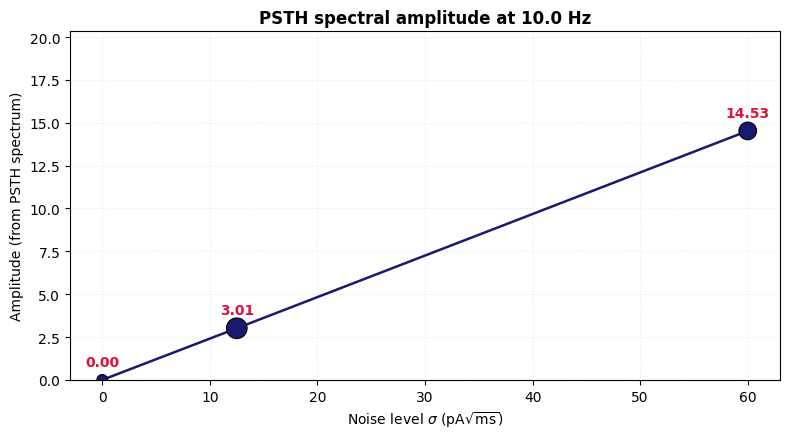

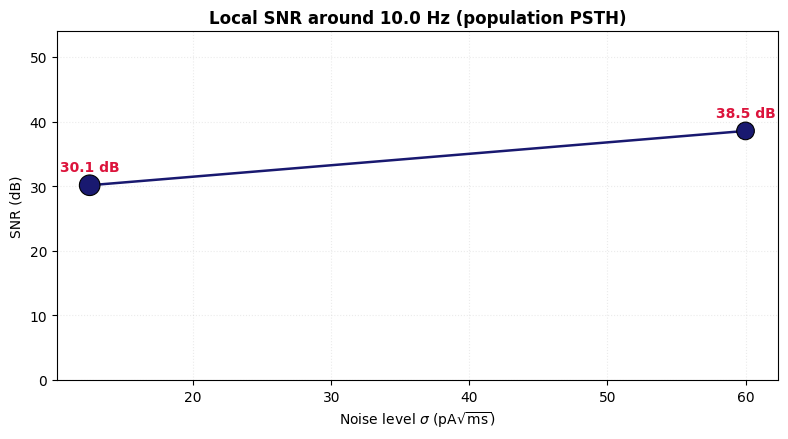

In [ ]:
def plot_psth_readout_summary(results, f_hz):
    results = sorted(results, key=lambda r: r["sigma"])

    sigmas = np.array([r["sigma"] for r in results], dtype=float)
    A10s   = np.array([r.get("A_10Hz", np.nan) for r in results], dtype=float)
    SNRdB  = np.array([r.get("SNR10_dB", np.nan) for r in results], dtype=float)
    Rvals  = np.array([r.get("R_pooled", np.nan) for r in results], dtype=float)

    def marker_sizes_from_r(r, s_min=60, s_max=220):
        r = np.nan_to_num(r, nan=0.0)
        if r.max() - r.min() > 1e-12:
            r_norm = (r - r.min()) / (r.max() - r.min())
        else:
            r_norm = np.zeros_like(r)
        return s_min + r_norm * (s_max - s_min)

    sizes = marker_sizes_from_r(Rvals)

    # Amplitude at 10 Hz
    plt.figure(figsize=(8, 4.5))
    plt.plot(sigmas, A10s, color="midnightblue", lw=1.8)
    plt.scatter(
        sigmas, A10s,
        s=sizes,
        color="midnightblue",
        edgecolors="black",
        linewidths=0.8,
        zorder=3
    )

    for x, y in zip(sigmas, A10s):
        if np.isfinite(y):
            plt.annotate(
                f"{y:.2f}",
                xy=(x, y), xytext=(0, 10),
                textcoords="offset points",
                ha="center",
                fontsize=10,
                fontweight="bold",
                color="crimson"
            )

    valid_A = A10s[np.isfinite(A10s)]
    if valid_A.size > 0:
        plt.ylim(0, valid_A.max() * 1.4)

    plt.title(f"PSTH spectral amplitude at {f_hz:.1f} Hz", fontweight="bold")
    plt.xlabel(r"Noise level $\sigma$ (pA$\sqrt{\mathrm{ms}}$)")
    plt.ylabel("Amplitude (from PSTH spectrum)")
    plt.grid(alpha=0.25, linestyle=":")
    plt.tight_layout()
    plt.show()

    # SNR at 10 Hz
    plt.figure(figsize=(8, 4.5))
    plt.plot(sigmas, SNRdB, color="midnightblue", lw=1.8)
    plt.scatter(
        sigmas, SNRdB,
        s=sizes,
        color="midnightblue",
        edgecolors="black",
        linewidths=0.8,
        zorder=3
    )

    for x, y in zip(sigmas, SNRdB):
        if np.isfinite(y):
            plt.annotate(
                f"{y:.1f} dB",
                xy=(x, y), xytext=(0, 10),
                textcoords="offset points",
                ha="center",
                fontsize=10,
                fontweight="bold",
                color="crimson"
            )

    valid_SNR = SNRdB[np.isfinite(SNRdB)]
    if valid_SNR.size > 0:
        plt.ylim(0, valid_SNR.max() * 1.4)

    plt.title(f"Local SNR around {f_hz:.1f} Hz (population PSTH)", fontweight="bold")
    plt.xlabel(r"Noise level $\sigma$ (pA$\sqrt{\mathrm{ms}}$)")
    plt.ylabel("SNR (dB)")
    plt.grid(alpha=0.25, linestyle=":")
    plt.tight_layout()
    plt.show()


plot_psth_readout_summary(results, f_hz=f_hz)

The final summary plots report the *10 Hz* PSTH amplitude and the corresponding local SNR as functions of the noise intensity. Both measures exhibit a clear enhancement at intermediate-to-high noise levels, revealing a population-level signature of Stochastic Resonance in the frequency domain.

Notably, the noise regime that maximizes the spectral readout does not coincide with maximal Vector Strength. While phase locking peaks at intermediate noise, the strongest frequency-specific population signal is observed when the firing rate is sufficiently high to support a stable PSTH oscillation. This result emphasizes that, at the population level, Stochastic Resonance reflects a balance between synchronization and spike availability rather than precise phase locking alone.

This frequency-domain analysis provides a complementary and more biologically plausible readout of Stochastic Resonance. It shows how noise can enhance the transmission of temporal structure in neural populations, even beyond the regime of optimal spike-level synchronization, thereby closing the link between single-neuron dynamics and population-level signal processing.

## **Conclusion**

This work demonstrates that Stochastic Resonance emerges naturally from the interaction between threshold dynamics, noise, and temporal structure in both single neurons and neural populations. At the single-neuron level, an optimal noise intensity maximizes spike-level phase locking, enabling reliable temporal encoding of a subthreshold sinusoidal input. Crucially, the optimal noise level is not fixed but adapts systematically to input amplitude and bias current, confirming that SR is a contextual rather than intrinsic property of the neuron.

At the population level, independent noise realizations across neurons transform sparse, phase-locked spiking into coherent collective signals. Population readouts such as pooled PSTHs and circular phase distributions reveal that strong temporal structure can emerge even at low firing rates. Frequency-domain analysis further shows that population-level spectral amplification does not strictly require maximal spike-level synchronization: while phase locking peaks at intermediate noise, the strongest frequency-specific PSTH components occur at higher noise levels where spike availability increases.

Together, these results highlight that Stochastic Resonance optimizes temporal structure rather than excitability, and that different readout mechanisms capture complementary aspects of neural coding. The study bridges single-neuron dynamics and population-level signal processing, offering a unified framework to understand how noise can enhance temporal information transmission in neural systems.

## **Limitations and Future Works**

The present study deliberately isolates the role of noise by considering independent, identical neurons without synaptic coupling or network interactions. While this allows for a clear mechanistic interpretation, real neural circuits exhibit heterogeneity, recurrent connectivity, and correlated noise, all of which may significantly shape population-level Stochastic Resonance.

A further methodological limitation concerns the estimation of phase locking, which is conditioned on trials exhibiting a minimum number of spikes. While this criterion ensures statistical reliability of the phase-locking measure, it may introduce a mild selection bias by preferentially retaining trials with higher responsiveness, particularly at low noise levels. This effect does not alter the qualitative trends observed but should be considered when interpreting absolute values ​​of the locking strength.

Future work could extend this framework by introducing neuronal diversity, shared noise sources, and synaptic interactions to assess how SR scales in realistic network architectures. Additionally, exploring alternative neuron models and adaptive mechanisms could clarify the robustness of the observed effects across different dynamical regimes. Finally, extending the frequency-domain analysis to broader signal spectra and time-varying inputs would further strengthen the link between SR and biologically plausible neural coding strategies.